# Trabajo Práctico 2: Predicción de lluvia

Integrantes:

* Zahradnicek Ezequiel



# Contexto del problema

El dataset se llama weatherAUS.csv y contiene información climática de Australia de los últimos años, incluyendo si para el día siguiente llovió o no en la columna ‘RainTomorrow’. El objetivo es la predicción de esta variable en función del resto de las características.


In [ ]:
!pip install pycaret

In [ ]:
!pip install optuna
import shap
import time
import random
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras import backend as K
import matplotlib.pyplot as plt
from pycaret.classification import *
from tensorflow.keras import Sequential
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.impute import KNNImputer
from sklearn.metrics import confusion_matrix, f1_score, classification_report, roc_curve, roc_auc_score, auc, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, RobustScaler, PowerTransformer

# 1. Análisis descriptivo

Realizar un análisis descriptivo que ayude a la comprensión del problema, de cada una de las variables involucradas, detallando: características, comportamiento y rango de variación. ¿Qué es cada variable?

* Análisis y decisión sobre datos faltantes.
* Visualización de datos (por ejemplo histogramas, scatterplots entre variables, diagramas de caja)
* ¿Está balanceado el dataset? ¿Por qué cree que hacemos esta pregunta?
* Codificación de variables categóricas (si se van a utilizar para predicción).
* Matriz de correlación de variables.
* Estandarización/escalado de datos.
* Validación cruzada train - test. Realizar una división del conjunto de datos en conjuntos de entrenamiento y prueba (y si se quiere, se puede incluir validación, que luego será útil) en el MOMENTO donde lo crean adecuado.

## Analisis exploratorio

### Variables y nulos

In [3]:
df = pd.read_csv('weatherAUS.csv')
df.head()

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2         WSW           46.0          W  ...        38.0         30.0   
3          NE           24.0         SE  ...        45.0         16.0   
4           W           41.0        ENE  ...        82.0         33.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1007.7       1007.1       8.0       NaN     16.9     21.8         No   
1       1010.6       1007.8       NaN       NaN     17.2     24.3         No   
2       1007.6       1008.7       NaN       2.0     21.0     23.2         No   
3       1017.6       1012.8       NaN       NaN     18.1     26.5         No   
4       1010.8       1006.0       7.0       8.0     17.8     29.7         No   

   RainTomorrow  
0            No  
1            No  
2            No  
3            No  
4            No  

[5 rows x 23 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [5]:
# Resumen estadístico
# Exploramos rango, media, mediana, desviación estándar
summary = df.describe()
print(summary)

             MinTemp        MaxTemp       Rainfall   Evaporation  \
count  143975.000000  144199.000000  142199.000000  82670.000000   
mean       12.194034      23.221348       2.360918      5.468232   
std         6.398495       7.119049       8.478060      4.193704   
min        -8.500000      -4.800000       0.000000      0.000000   
25%         7.600000      17.900000       0.000000      2.600000   
50%        12.000000      22.600000       0.000000      4.800000   
75%        16.900000      28.200000       0.800000      7.400000   
max        33.900000      48.100000     371.000000    145.000000   

           Sunshine  WindGustSpeed   WindSpeed9am   WindSpeed3pm  \
count  75625.000000  135197.000000  143693.000000  142398.000000   
mean       7.611178      40.035230      14.043426      18.662657   
std        3.785483      13.607062       8.915375       8.809800   
min        0.000000       6.000000       0.000000       0.000000   
25%        4.800000      31.000000       7.0000

In [6]:
print(df.isnull().sum())

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64


Contamos con 145460 registros, de tipo float64 y object. Se encuentran valores faltantes.

### Eliminación de nulos de la variable target

In [7]:
df['RainTomorrow'].isna().sum()

3267

In [8]:
# Eliminamos los registros donde hay faltantes en la columna target.
df.dropna(subset=['RainTomorrow'], inplace=True)
df['RainTomorrow'].isnull().sum()

0

Se eliminan los nulos de la variable target porque si hay valores faltantes en esta variable, el modelo de clasificación no podrá aprender de esos casos.

### Selección de cuidades de forma aleatoria y dropeo de Location

In [9]:
# lista_cuidades = df['Location'].unique().tolist()
# cuidades_aleatorias = random.sample(lista_cuidades, 10)

In [10]:
cuidades_aleatorias = ['Mildura', 'Sale', 'Brisbane', 'Melbourne', 'Sydney', 'Moree', 'NorahHead', 'Portland', 'Ballarat', 'Albany']

Al inicio del trabajo práctico, se seleccionaron 10 ciudades de forma aleatoria. Como no se deseaba que estas ciudades cambiaran cada vez que se ejecutaba el código, se decidio instanciarlas en una lista fija. Sin embargo, también se podría comentar esta lista y permitir que el usuario elija instanciarla de forma aleatoria en cada ejecución, según su preferencia.

In [11]:
df = df[df['Location'].isin(cuidades_aleatorias)]
df['Location'].unique()

array(['Moree', 'NorahHead', 'Sydney', 'Ballarat', 'Sale', 'Melbourne',
       'Mildura', 'Portland', 'Brisbane', 'Albany'], dtype=object)

In [12]:
df = df.drop('Location', axis=1)

Decidimos eliminar la variable 'Location', que representa la ciudad de donde se obtienen los datos. Consideramos que la ciudad en sí misma no es el factor determinante.

En lugar de eso, lo que realmente influye en las precipitaciones son las características ambientales de la zona, como la humedad del aire, la presencia de nubes y otras variables climáticas.

Por lo tanto, nuestras variables climáticas existentes son las que realmente capturan la dinámica que determina si va a llover o no. Al eliminar 'Location', evitamos incluir información redundante que no aporta valor adicional al modelo.

## División del dataset

In [13]:
X = df.drop('RainTomorrow', axis=1)
y = df['RainTomorrow'].map({'Yes': 1, 'No': 0})

Consideramos que la clase positiva corresponde a cuando llueve, mientras que la clase negativa se refiere a cuando no llueve. Por lo tanto, se mapea la variable target de esta manera.

In [14]:
# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((23810, 21), (5953, 21), (23810,), (5953,))

In [16]:
len(y_train[y==1]), len(y_train[y==0])

(5800, 18010)

Nuestras clases en el conjunto de entrenamiento están desbalanceadas, lo que sugiere que podría ser necesario realizar oversampling o undersampling, o bien utilizar un modelo de regresión que dé más peso a una clase sobre la otra.

Como utilizaremos un modelo de regresión logística que pondere más la clase minoritaria, nuestra métrica deberá tener en cuenta el desbalanceo de clases.

### Histogramas de las variables y boxplots

Al imputar valores faltantes, es importante considerar la distribución de las variables y la cantidad de valores atípicos presentes en ellas. Por lo tanto, se propone realizar histogramas y boxplots de las distribuciones.

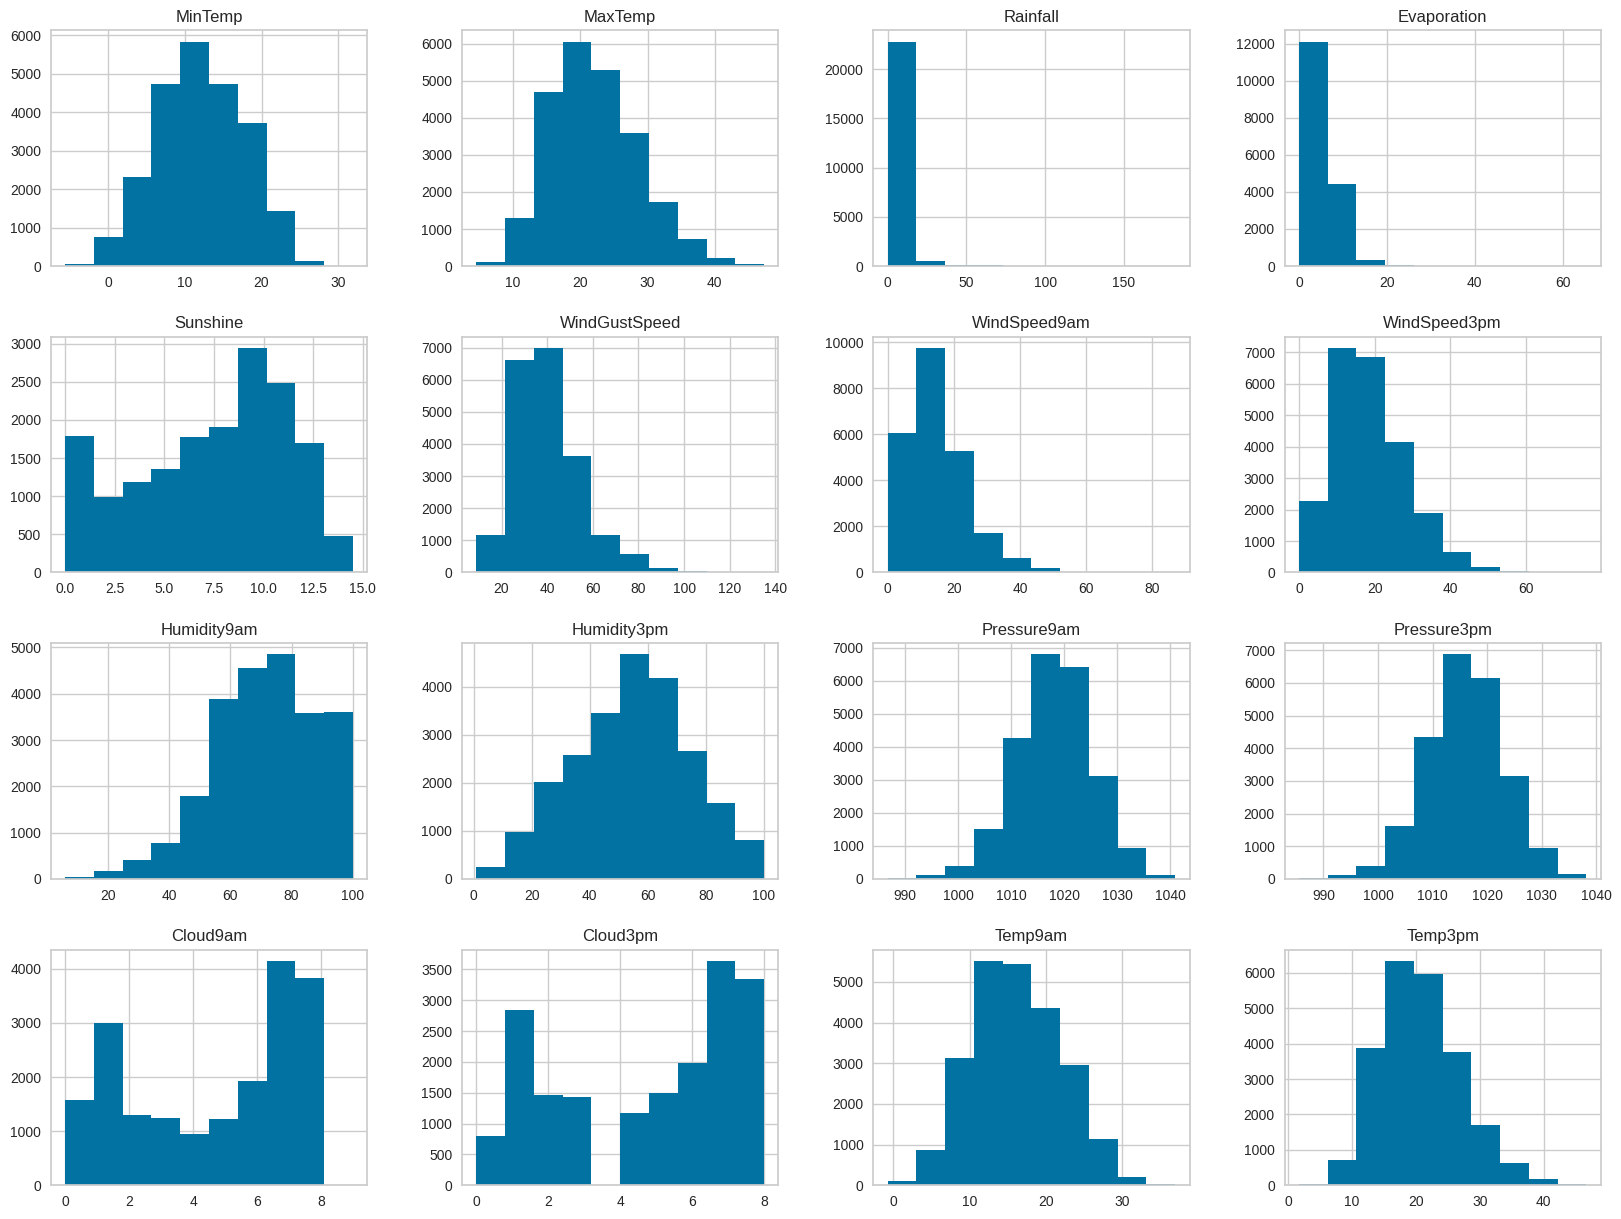

In [17]:
X_train.hist(figsize=(20, 15))
plt.show()

Se puede observar que muchas de nuestras variables tienen una distribución normal. Sin embargo, algunas presentan una distribución bimodal, mientras que otras siguen una distribución log-normal.

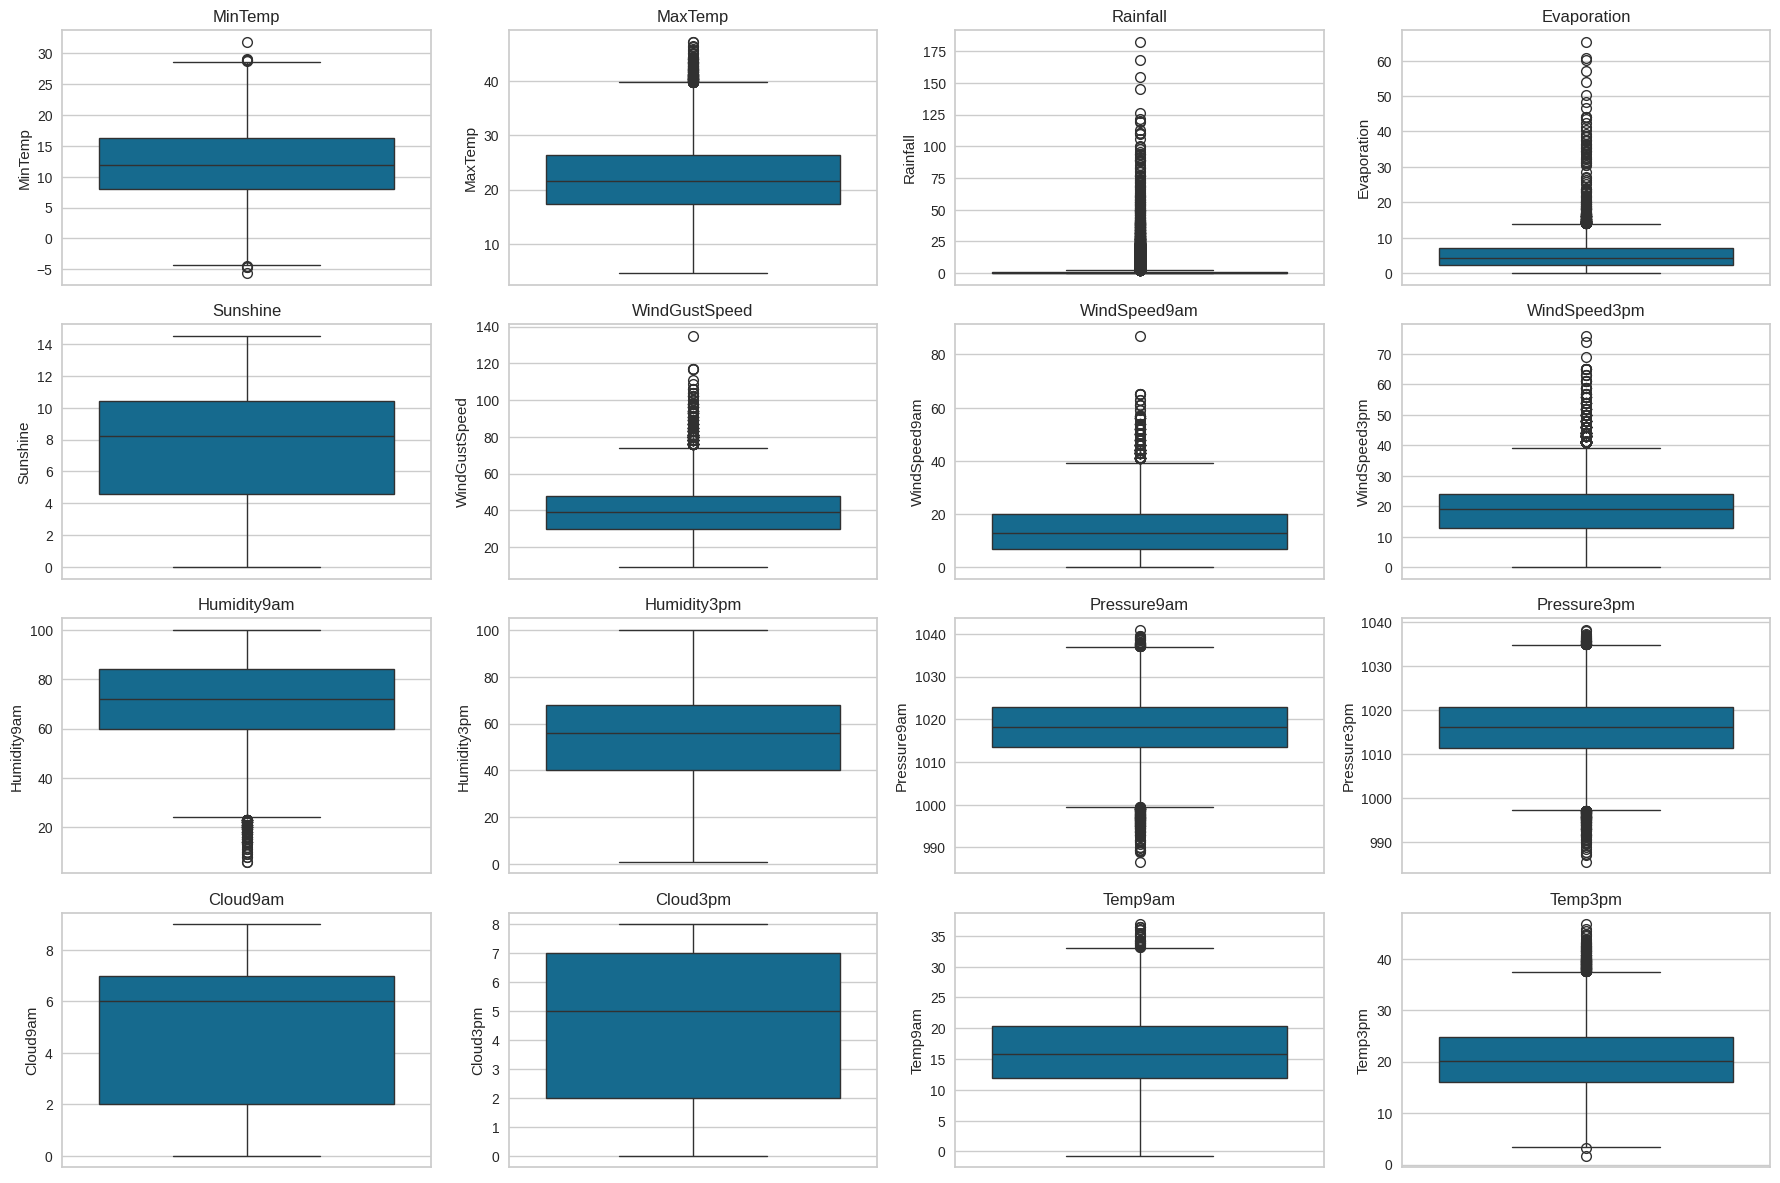

In [18]:
binary_columns = [col for col in X_train.columns if X_train[col].nunique() == 2]
non_binary_columns = [col for col in X_train.select_dtypes(include='number').columns if col not in binary_columns]
X_train_non_binary = X_train[non_binary_columns]

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(X_train_non_binary.columns):
    sns.boxplot(y=X_train_non_binary[col], ax=axes[i])
    axes[i].set_title(col)

for i in range(len(X_train_non_binary.columns), len(axes)):
    fig.delaxes(axes[i])

# Ajustar diseño
plt.tight_layout()
plt.show()

Como se mencionó anteriormente, aunque muchas variables presentan una distribución normal, estas distribuciones están ligeramente sesgadas. Otras variables siguen una distribución log-normal, mientras que algunas muestran una distribución más uniforme.

Se observa una gran cantidad de valores atípicos en las variables con distribuciones log-normales o normales sesgadas, pero no se detectan valores atípicos en variables con distribuciones bimodales ni en aquellas como Sunshine, que tiene una distribución uniforme.

Tampoco se detectan valores atipicos en la variable Humidity3pm dado que tiene una distribucion normal con muy poco sesgo.


La variable con la mayor cantidad de valores atípicos es Rainfall debido problablemente a la diversidad de cuidades y por lo tanto zonas climaticas.

## Codificación de variables categóricas

### Codificación cíclica de la fecha por el día del año


In [19]:
X_train['Date'].isna().sum(), X_test['Date'].isna().sum()

(0, 0)

In [20]:
X_train.head()

Date  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
76264  2012-08-07      5.8     15.7       1.6          1.0       7.9   
57889  2016-10-16     10.5     16.2       0.0          NaN       NaN   
62764  2013-07-30      5.0     14.8       0.6          1.6       2.8   
63699  2016-02-20     14.4     21.9       0.0          NaN       NaN   
77054  2014-12-04     14.0     20.3      12.6          1.4       5.4   

      WindGustDir  WindGustSpeed WindDir9am WindDir3pm  ...  WindSpeed3pm  \
76264         NNW           54.0        NNW        NNW  ...          26.0   
57889           N           59.0        NNE        NNW  ...          28.0   
62764         WSW           33.0          W         SW  ...          20.0   
63699          SE           37.0        WNW        ESE  ...          19.0   
77054         SSW           26.0          E          S  ...          17.0   

       Humidity9am  Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  \
76264         75.0         53.0       1019.2       1015.2       7.0       7.0   
57889         81.0         84.0       1002.2       1000.8       8.0       8.0   
62764         90.0         51.0       1021.6       1022.0       8.0       6.0   
63699         63.0         49.0       1022.2       1022.5       8.0       8.0   
77054         99.0         83.0       1011.1       1011.2       8.0       8.0   

       Temp9am  Temp3pm  RainToday  
76264      9.2     14.7        Yes  
57889     11.9     13.5         No  
62764     10.0     12.5         No  
63699     16.7     20.7         No  
77054     15.7     18.1        Yes  

[5 rows x 21 columns]

In [21]:
def enconder_fecha(df, column_date):

  df[column_date] = pd.to_datetime(df[column_date])

  df['day_of_year'] = df[column_date].dt.dayofyear

  df.drop(columns=[column_date], inplace=True)

  df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
  df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

  df.drop(columns=['day_of_year'], inplace=True)

Al codificar la fecha de forma cíclica por el día del año, estoy transformando el día en un formato que refleja su posición en un ciclo continuo.

Esta codificación permite capturar la naturaleza cíclica del tiempo, donde el día 1 y el día 365 están más cercanos entre sí, a pesar de estar separados en una representación lineal. De esta manera, se preservan las relaciones temporales, evitando que el modelo interprete incorrectamente que hay una distancia significativa entre esos días.

In [22]:
enconder_fecha(X_train, 'Date')
enconder_fecha(X_test, 'Date')

In [23]:
X_train.head()

MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine WindGustDir  \
76264      5.8     15.7       1.6          1.0       7.9         NNW   
57889     10.5     16.2       0.0          NaN       NaN           N   
62764      5.0     14.8       0.6          1.6       2.8         WSW   
63699     14.4     21.9       0.0          NaN       NaN          SE   
77054     14.0     20.3      12.6          1.4       5.4         SSW   

       WindGustSpeed WindDir9am WindDir3pm  WindSpeed9am  ...  Humidity3pm  \
76264           54.0        NNW        NNW          26.0  ...         53.0   
57889           59.0        NNE        NNW          24.0  ...         84.0   
62764           33.0          W         SW          15.0  ...         51.0   
63699           37.0        WNW        ESE          11.0  ...         49.0   
77054           26.0          E          S           9.0  ...         83.0   

       Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  \
76264       1019.2       1015.2       7.0       7.0      9.2     14.7   
57889       1002.2       1000.8       8.0       8.0     11.9     13.5   
62764       1021.6       1022.0       8.0       6.0     10.0     12.5   
63699       1022.2       1022.5       8.0       8.0     16.7     20.7   
77054       1011.1       1011.2       8.0       8.0     15.7     18.1   

       RainToday  day_of_year_sin day_of_year_cos  
76264        Yes        -0.601624       -0.798779  
57889         No        -0.961130        0.276097  
62764         No        -0.471160       -0.882048  
63699         No         0.769415        0.638749  
77054        Yes        -0.448229        0.893919  

[5 rows x 22 columns]

### Codificación de direcciones cardinales como senos y cosenos

In [24]:
def enconder_direcciones(df, column_name):

  order = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']

  # Inicializar el encoder
  encoder = OrdinalEncoder(categories=[order], handle_unknown='use_encoded_value', unknown_value=np.nan)

  # Codificar las direcciones
  angles = encoder.fit_transform(df[column_name].values.reshape(-1, 1))

  # Convertir a ángulos
  df[column_name] = angles * 22.5

  df[column_name + '_sin'] = np.sin(np.deg2rad(df[column_name]))
  df[column_name + '_cos'] = np.cos(np.deg2rad(df[column_name]))

  df.drop(columns=[column_name], inplace=True)

Actualmente, estamos codificando direcciones cardinales como ángulos, donde cada dirección se representa en un formato ordinal que sigue el sentido de las agujas del reloj.

Posteriormente, convertimos estos ángulos en una codificación cíclica. Como ya explicamos esta transformación es esencial para capturar la naturaleza cíclica de las direcciones.

In [25]:
X_train.head()

MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine WindGustDir  \
76264      5.8     15.7       1.6          1.0       7.9         NNW   
57889     10.5     16.2       0.0          NaN       NaN           N   
62764      5.0     14.8       0.6          1.6       2.8         WSW   
63699     14.4     21.9       0.0          NaN       NaN          SE   
77054     14.0     20.3      12.6          1.4       5.4         SSW   

       WindGustSpeed WindDir9am WindDir3pm  WindSpeed9am  ...  Humidity3pm  \
76264           54.0        NNW        NNW          26.0  ...         53.0   
57889           59.0        NNE        NNW          24.0  ...         84.0   
62764           33.0          W         SW          15.0  ...         51.0   
63699           37.0        WNW        ESE          11.0  ...         49.0   
77054           26.0          E          S           9.0  ...         83.0   

       Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  \
76264       1019.2       1015.2       7.0       7.0      9.2     14.7   
57889       1002.2       1000.8       8.0       8.0     11.9     13.5   
62764       1021.6       1022.0       8.0       6.0     10.0     12.5   
63699       1022.2       1022.5       8.0       8.0     16.7     20.7   
77054       1011.1       1011.2       8.0       8.0     15.7     18.1   

       RainToday  day_of_year_sin day_of_year_cos  
76264        Yes        -0.601624       -0.798779  
57889         No        -0.961130        0.276097  
62764         No        -0.471160       -0.882048  
63699         No         0.769415        0.638749  
77054        Yes        -0.448229        0.893919  

[5 rows x 22 columns]

In [26]:
enconder_direcciones(X_train, 'WindGustDir')
enconder_direcciones(X_train, 'WindDir9am')
enconder_direcciones(X_train, 'WindDir3pm')

enconder_direcciones(X_test, 'WindGustDir')
enconder_direcciones(X_test, 'WindDir9am')
enconder_direcciones(X_test, 'WindDir3pm')

In [27]:
X_train.head()

MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
76264      5.8     15.7       1.6          1.0       7.9           54.0   
57889     10.5     16.2       0.0          NaN       NaN           59.0   
62764      5.0     14.8       0.6          1.6       2.8           33.0   
63699     14.4     21.9       0.0          NaN       NaN           37.0   
77054     14.0     20.3      12.6          1.4       5.4           26.0   

       WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  ...  Temp3pm  \
76264          26.0          26.0         75.0         53.0  ...     14.7   
57889          24.0          28.0         81.0         84.0  ...     13.5   
62764          15.0          20.0         90.0         51.0  ...     12.5   
63699          11.0          19.0         63.0         49.0  ...     20.7   
77054           9.0          17.0         99.0         83.0  ...     18.1   

       RainToday  day_of_year_sin  day_of_year_cos  WindGustDir_sin  \
76264        Yes        -0.601624        -0.798779        -0.382683   
57889         No        -0.961130         0.276097         0.000000   
62764         No        -0.471160        -0.882048        -0.923880   
63699         No         0.769415         0.638749         0.707107   
77054        Yes        -0.448229         0.893919        -0.382683   

       WindGustDir_cos WindDir9am_sin  WindDir9am_cos  WindDir3pm_sin  \
76264         0.923880      -0.382683    9.238795e-01   -3.826834e-01   
57889         1.000000       0.382683    9.238795e-01   -3.826834e-01   
62764        -0.382683      -1.000000   -1.836970e-16   -7.071068e-01   
63699        -0.707107      -0.923880    3.826834e-01    9.238795e-01   
77054        -0.923880       1.000000    6.123234e-17    1.224647e-16   

       WindDir3pm_cos  
76264        0.923880  
57889        0.923880  
62764       -0.707107  
63699       -0.382683  
77054       -1.000000  

[5 rows x 25 columns]

### Codificación de RainToday a variable binaria

In [28]:
X_train.head()

MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
76264      5.8     15.7       1.6          1.0       7.9           54.0   
57889     10.5     16.2       0.0          NaN       NaN           59.0   
62764      5.0     14.8       0.6          1.6       2.8           33.0   
63699     14.4     21.9       0.0          NaN       NaN           37.0   
77054     14.0     20.3      12.6          1.4       5.4           26.0   

       WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  ...  Temp3pm  \
76264          26.0          26.0         75.0         53.0  ...     14.7   
57889          24.0          28.0         81.0         84.0  ...     13.5   
62764          15.0          20.0         90.0         51.0  ...     12.5   
63699          11.0          19.0         63.0         49.0  ...     20.7   
77054           9.0          17.0         99.0         83.0  ...     18.1   

       RainToday  day_of_year_sin  day_of_year_cos  WindGustDir_sin  \
76264        Yes        -0.601624        -0.798779        -0.382683   
57889         No        -0.961130         0.276097         0.000000   
62764         No        -0.471160        -0.882048        -0.923880   
63699         No         0.769415         0.638749         0.707107   
77054        Yes        -0.448229         0.893919        -0.382683   

       WindGustDir_cos WindDir9am_sin  WindDir9am_cos  WindDir3pm_sin  \
76264         0.923880      -0.382683    9.238795e-01   -3.826834e-01   
57889         1.000000       0.382683    9.238795e-01   -3.826834e-01   
62764        -0.382683      -1.000000   -1.836970e-16   -7.071068e-01   
63699        -0.707107      -0.923880    3.826834e-01    9.238795e-01   
77054        -0.923880       1.000000    6.123234e-17    1.224647e-16   

       WindDir3pm_cos  
76264        0.923880  
57889        0.923880  
62764       -0.707107  
63699       -0.382683  
77054       -1.000000  

[5 rows x 25 columns]

In [29]:
X_train['RainToday'] = X_train['RainToday'].map({'Yes': 1, 'No': 0})
X_test['RainToday'] = X_test['RainToday'].map({'Yes': 1, 'No': 0})

In [30]:
X_train.head()

MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
76264      5.8     15.7       1.6          1.0       7.9           54.0   
57889     10.5     16.2       0.0          NaN       NaN           59.0   
62764      5.0     14.8       0.6          1.6       2.8           33.0   
63699     14.4     21.9       0.0          NaN       NaN           37.0   
77054     14.0     20.3      12.6          1.4       5.4           26.0   

       WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  ...  Temp3pm  \
76264          26.0          26.0         75.0         53.0  ...     14.7   
57889          24.0          28.0         81.0         84.0  ...     13.5   
62764          15.0          20.0         90.0         51.0  ...     12.5   
63699          11.0          19.0         63.0         49.0  ...     20.7   
77054           9.0          17.0         99.0         83.0  ...     18.1   

       RainToday  day_of_year_sin  day_of_year_cos  WindGustDir_sin  \
76264        1.0        -0.601624        -0.798779        -0.382683   
57889        0.0        -0.961130         0.276097         0.000000   
62764        0.0        -0.471160        -0.882048        -0.923880   
63699        0.0         0.769415         0.638749         0.707107   
77054        1.0        -0.448229         0.893919        -0.382683   

       WindGustDir_cos  WindDir9am_sin  WindDir9am_cos  WindDir3pm_sin  \
76264         0.923880       -0.382683    9.238795e-01   -3.826834e-01   
57889         1.000000        0.382683    9.238795e-01   -3.826834e-01   
62764        -0.382683       -1.000000   -1.836970e-16   -7.071068e-01   
63699        -0.707107       -0.923880    3.826834e-01    9.238795e-01   
77054        -0.923880        1.000000    6.123234e-17    1.224647e-16   

       WindDir3pm_cos  
76264        0.923880  
57889        0.923880  
62764       -0.707107  
63699       -0.382683  
77054       -1.000000  

[5 rows x 25 columns]

## Imputación de datos faltantes

Si bien algunas variables presentan una distribución normal y, por lo tanto, se podría considerar la imputación de datos utilizando la mediana, esta opción no es aplicable en todas las distribuciones.

Por esta razón se eligió el método de imputación KNN. Así, se mejora la precisión de la imputación para todas las distribuciones sin mucho costo computacional agregado.

In [31]:
columns = X_train.columns

In [32]:
# Creamos el imputador KNN
knn_imputer = KNNImputer(n_neighbors=5)

X_train = knn_imputer.fit_transform(X_train)
X_test = knn_imputer.transform(X_test)

In [33]:
X_train = pd.DataFrame(X_train, columns=columns)
X_test = pd.DataFrame(X_test, columns=columns)

In [34]:
X_train.shape, X_test.shape

((23810, 25), (5953, 25))

## Distribuciones según la target

In [35]:
def boxplots(X, y):
    # Concatenar target y características
    data = pd.concat([X, y], axis=1)

    # Número de características
    num_features = X.shape[1]

    # Calcular el número de filas (máximo 5 gráficos por fila)
    num_cols = 5
    num_rows = (num_features + num_cols - 1) // num_cols  # Redondeo hacia arriba

    # Crear la figura y los ejes
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
    fig.subplots_adjust(hspace=0.5)

    # Si solo hay una fila, asegurar que 'axes' sea una lista
    if num_rows == 1:
        axes = np.expand_dims(axes, axis=0)

    # Aplanar los ejes para facilitar la indexación
    axes = axes.flatten()

    # Recorrer cada feature para generar su diagrama de caja respecto de la salida
    for i, feature in enumerate(data.columns[1:]):
        sns.boxplot(x='RainTomorrow', y=feature, data=data, ax=axes[i])
        axes[i].set_title(f'Diagrama de caja de {feature}')
        axes[i].set_xlabel('Target')
        axes[i].set_ylabel(feature)

    # Eliminar subplots vacíos si es necesario
    if num_features < len(axes):
        for i in range(num_features, len(axes)):
            fig.delaxes(axes[i])

    plt.show()


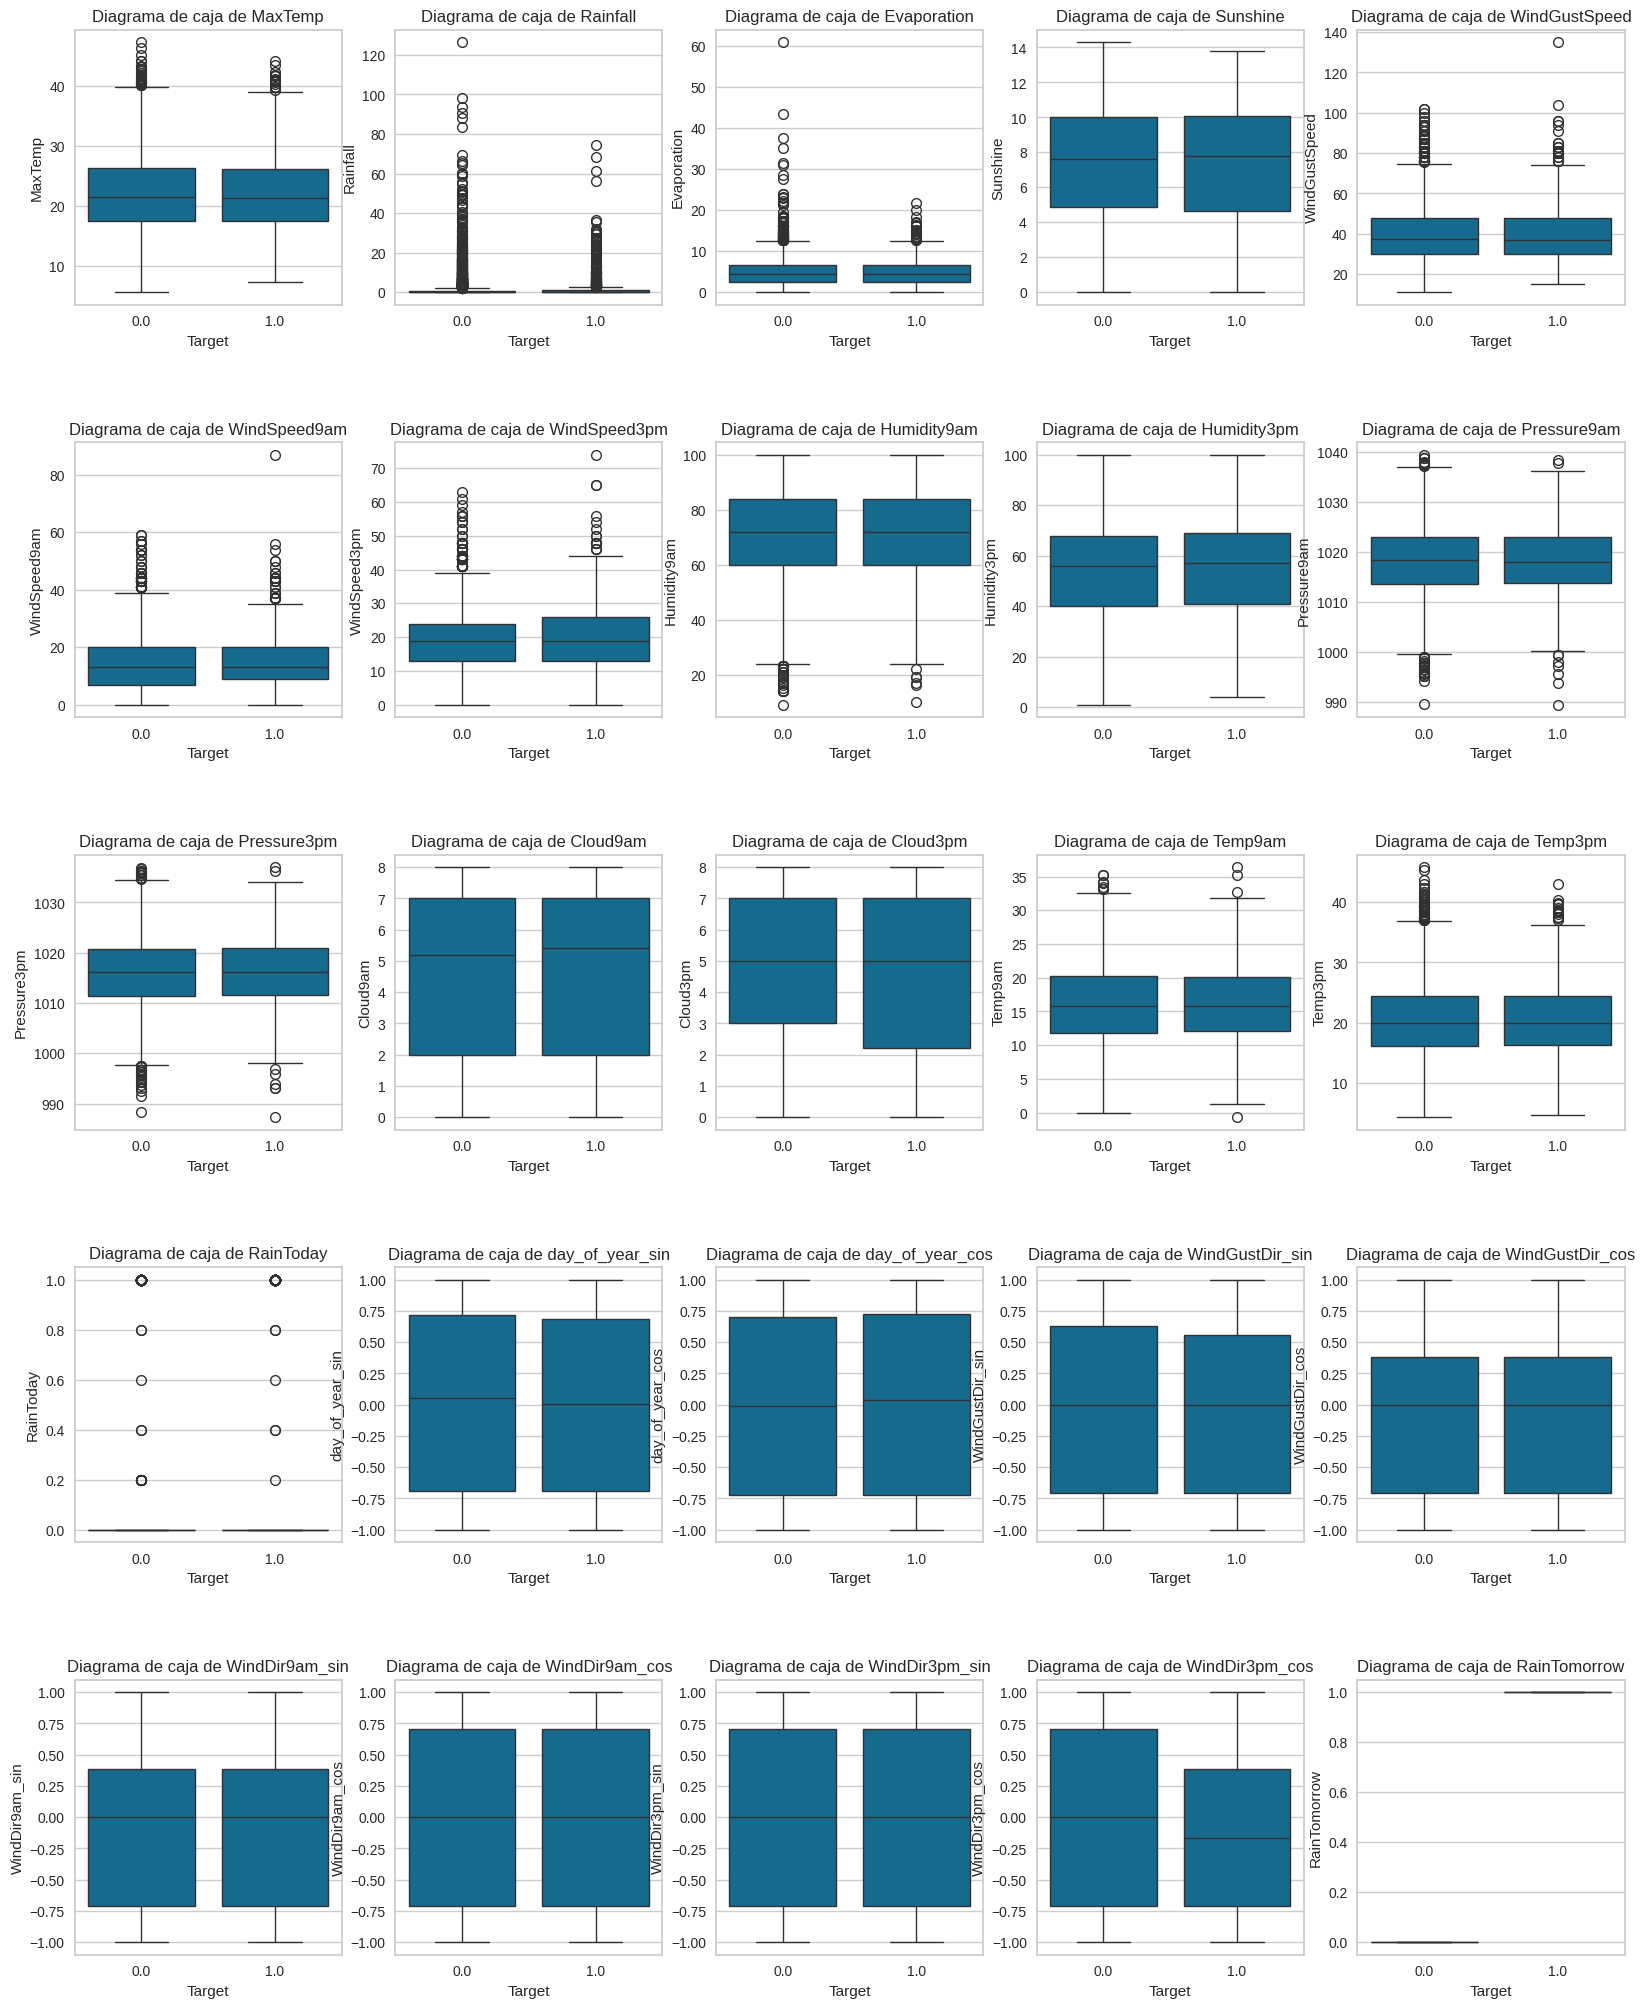

In [36]:
boxplots(X_train, y_train)

Al observar estos boxplots, notamos que la mayoría de las distribuciones son prácticamente iguales, independientemente de si pertenecen a la clase positiva o negativa.

Esto sugiere que, a primera vista, no hay ninguna variable que destaque como un predictor claro de la clase a la que pertenece cada observación.

In [37]:
def pairplot(X, y):

  # Descartamos las features binarias
  features = []
  for i in X.columns:
    if len(X[i].unique()) > 10:
      features.append(i)

  # Número de características
  num_features = len(features)

  # Calcular el número de filas (máximo 1 gráficos por fila)
  num_cols = 1
  num_rows = (num_features + num_cols - 1) // num_cols

  # Crear la figura y los ejes
  fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 5 * num_rows))

  # Aplanar los ejes para facilitar la indexación
  axes = axes.flatten()

  # Recorrer cada feature para generar su diagrama de caja respecto de la salida
  for i, feature in enumerate(features):
    if i < len(axes):
      sns.scatterplot(x=X[feature], y=y, ax=axes[i], hue=y, palette='Set1')
      axes[i].set_title(f'{feature} vs target')
    else:
      break

  # Eliminar subplots vacíos si es necesario
  if num_features < len(axes):
    for i in range(num_features, len(axes)):
      fig.delaxes(axes[i])

  plt.tight_layout()
  plt.show()

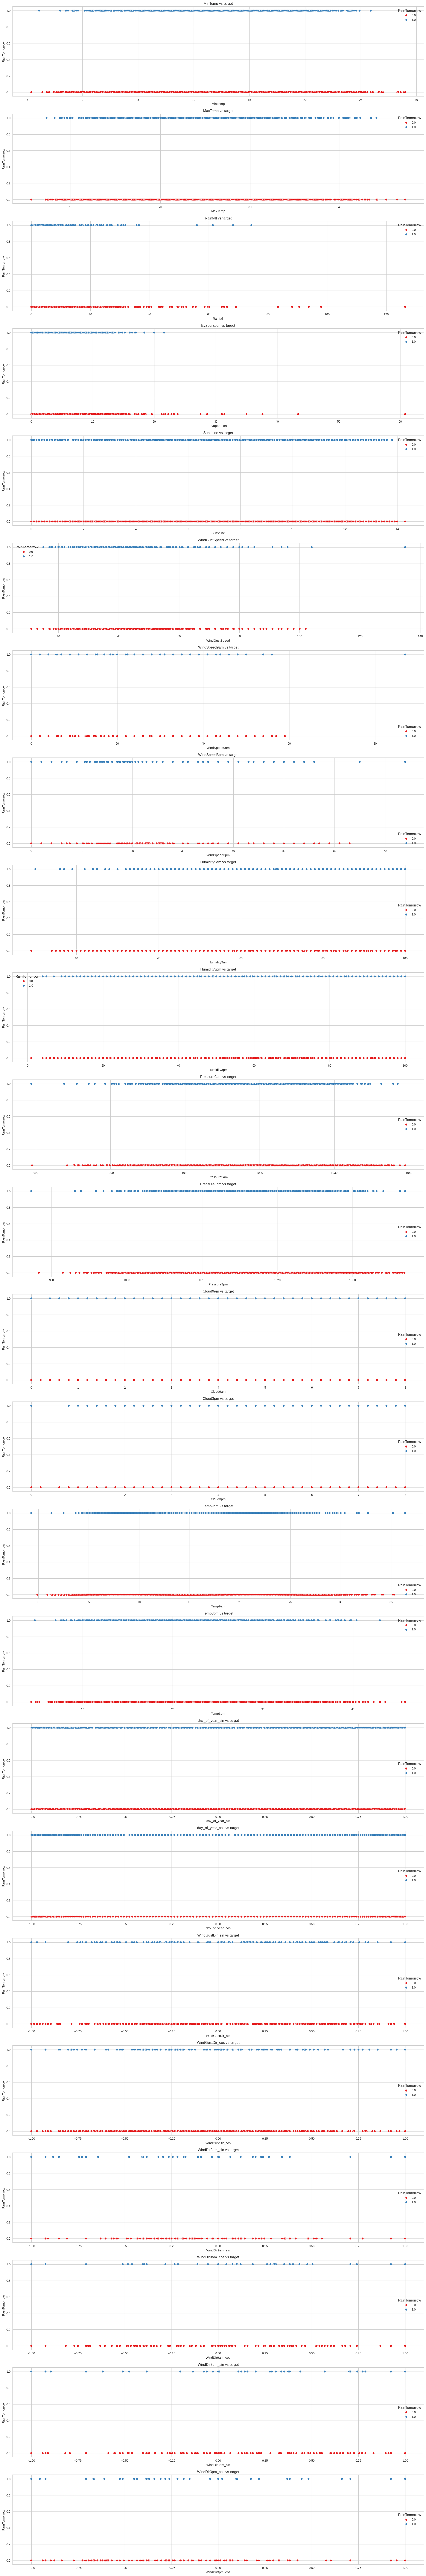

In [38]:
pairplot(X_train, y_train)

De igual forma observamos que los rangos de todas las distribuciones son prácticamente identicos. Esto es consistente con lo que se observó anteriormente en los boxplots, donde todas las variables mostraban una distribución similar.

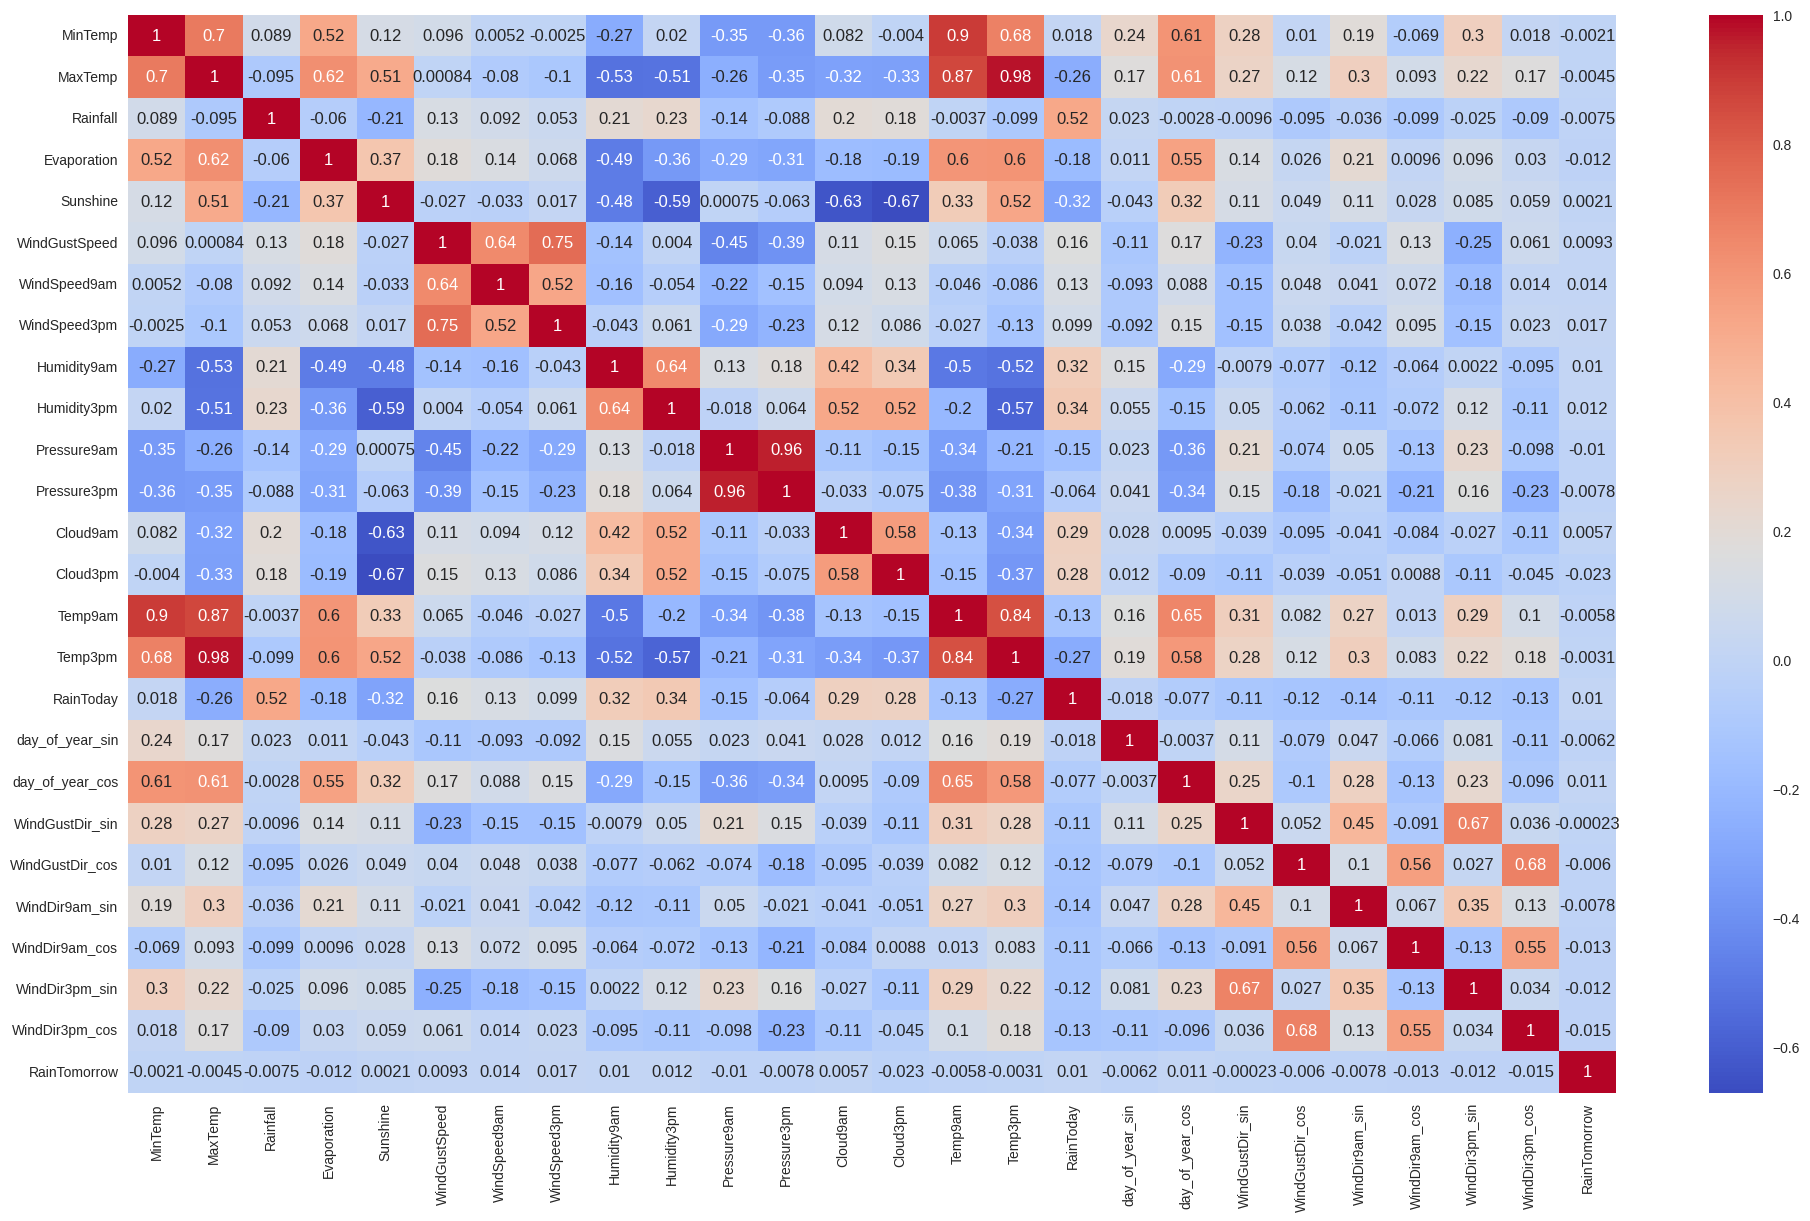

In [39]:
corr = pd.concat([X_train, y_train], axis=1).corr()

plt.figure(figsize=(24, 14))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

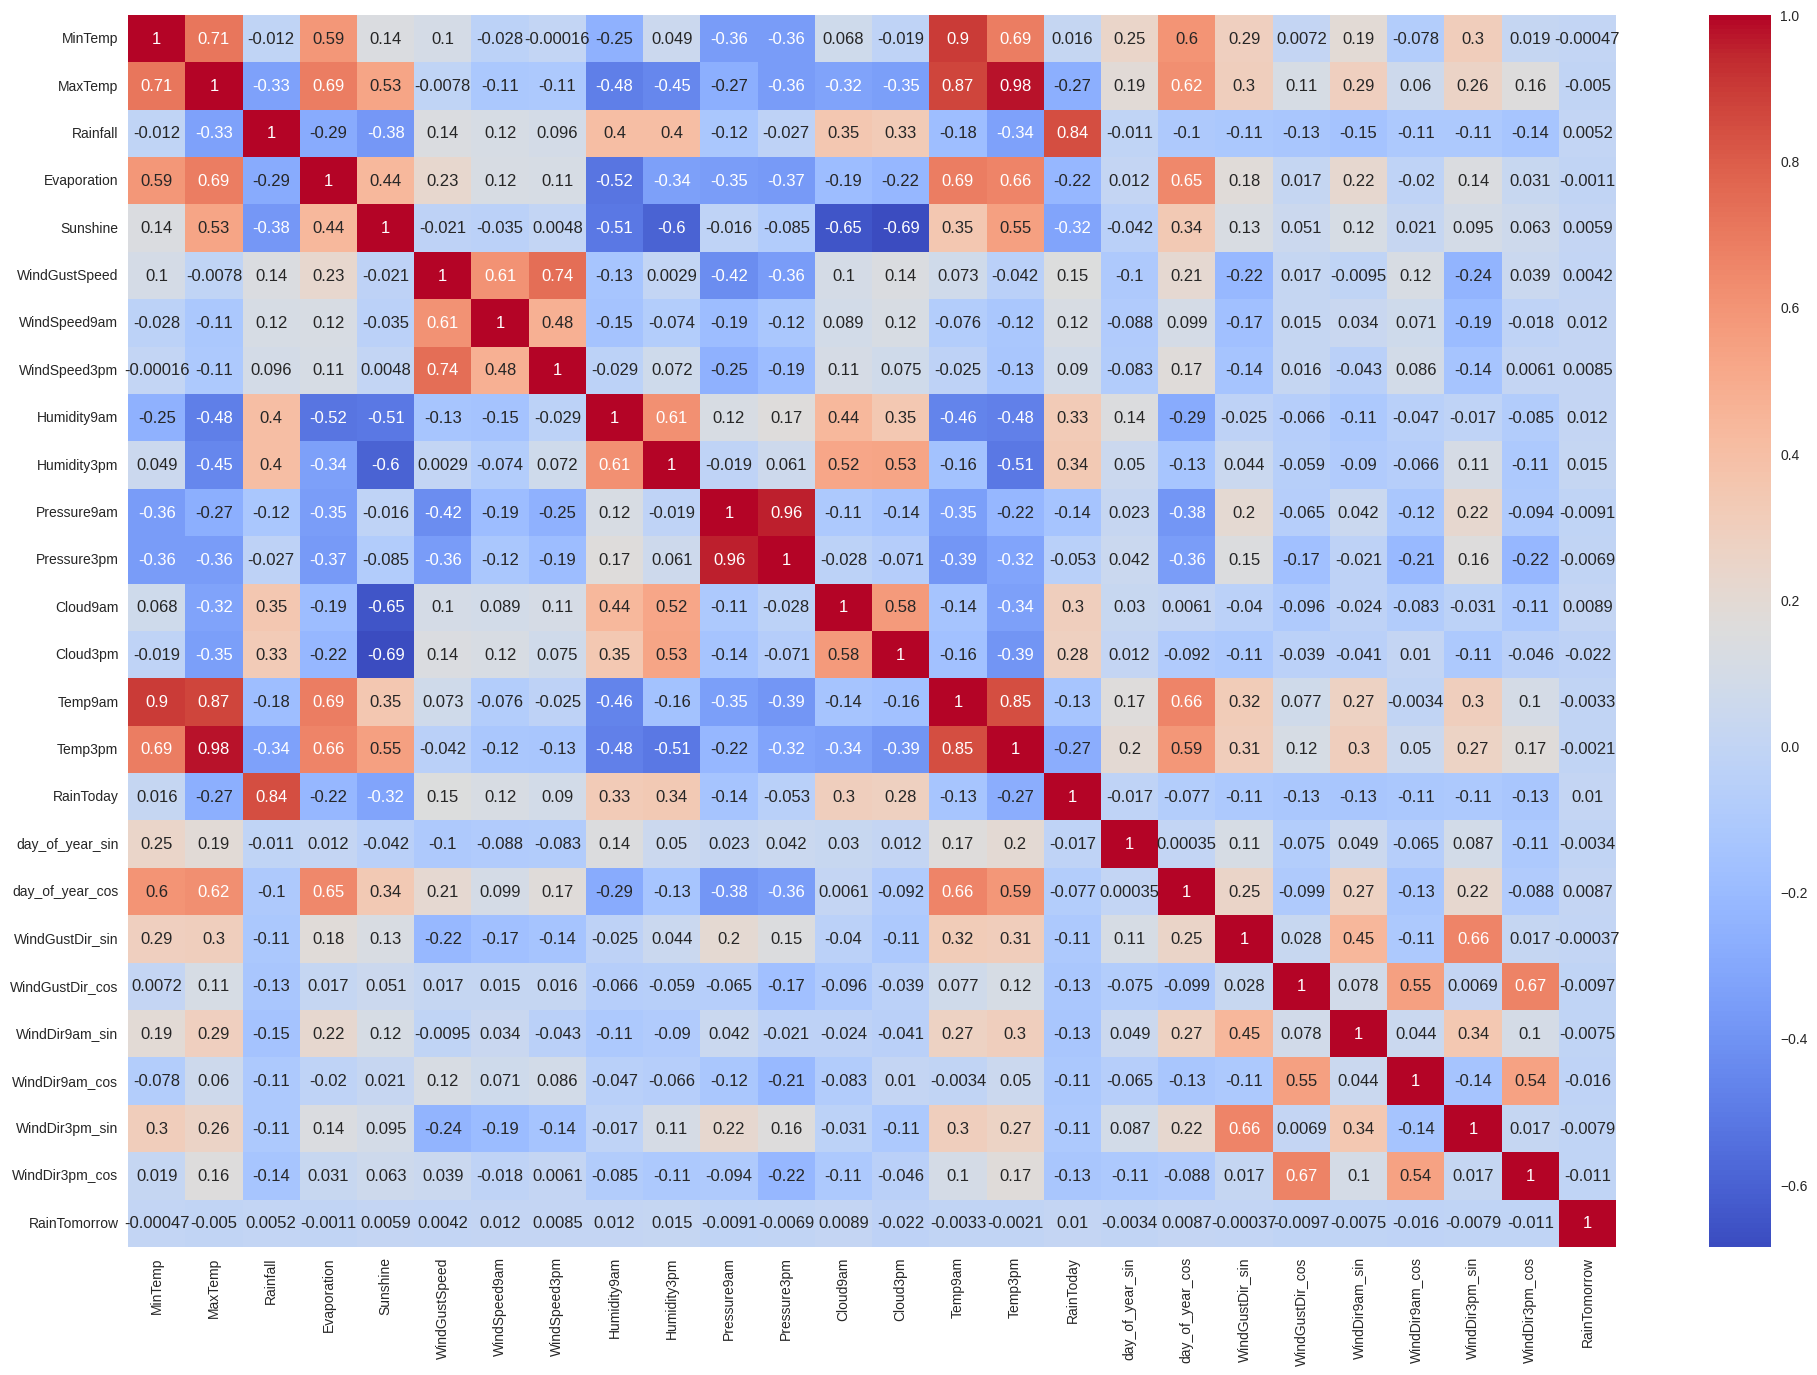

In [40]:
corr = pd.concat([X_train, y_train], axis=1).corr(method='spearman')

plt.figure(figsize=(24, 16))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

De igual manera con lo mencionado anteriormente, al examinar la matriz de correlación, se puede observar que la target no presenta correlaciones lineales ni de monotonía significativas con ninguna de las variables.

Esta falta de correlación sugiere que las relaciones entre la target y las demás variables son débiles, lo que implica que no hay patrones claros que puedan utilizarse para predecir la clase de la variable objetivo a partir de las características disponibles.

## Estandarización/escalado de datos.

In [41]:
columns = X_train.columns

In [42]:
columnas_binarias = [col for col in X_train.columns if X_train[col].nunique() == 2 and sorted(X_train[col].unique()) == [0, 1]]
columnas_trigonometricas = [col for col in X_train.columns if 'sin' in col or 'cos' in col]

colmunas_imputables = X_train.columns.difference(columnas_binarias).difference(columnas_trigonometricas)

power_transformer = PowerTransformer(method='yeo-johnson')
scaler = StandardScaler()

X_train[colmunas_imputables] = power_transformer.fit_transform(X_train[colmunas_imputables])
X_train[colmunas_imputables] = scaler.fit_transform(X_train[colmunas_imputables])

X_test[colmunas_imputables] = power_transformer.transform(X_test[colmunas_imputables])
X_test[colmunas_imputables] = scaler.transform(X_test[colmunas_imputables])

Es importante tener en cuenta que escalar las variables binarias y trigonométricas no solo no aporta valor al análisis, sino que puede complicar la interpretación de la información.

Por lo que excluimos estas columnas a la hora de transformar y escalar los datos, quedándonos únicamente con las columnas que no son ni binarias ni trigonométricas.

In [43]:
X_train = pd.DataFrame(X_train, columns=columns)
X_test = pd.DataFrame(X_test, columns=columns)

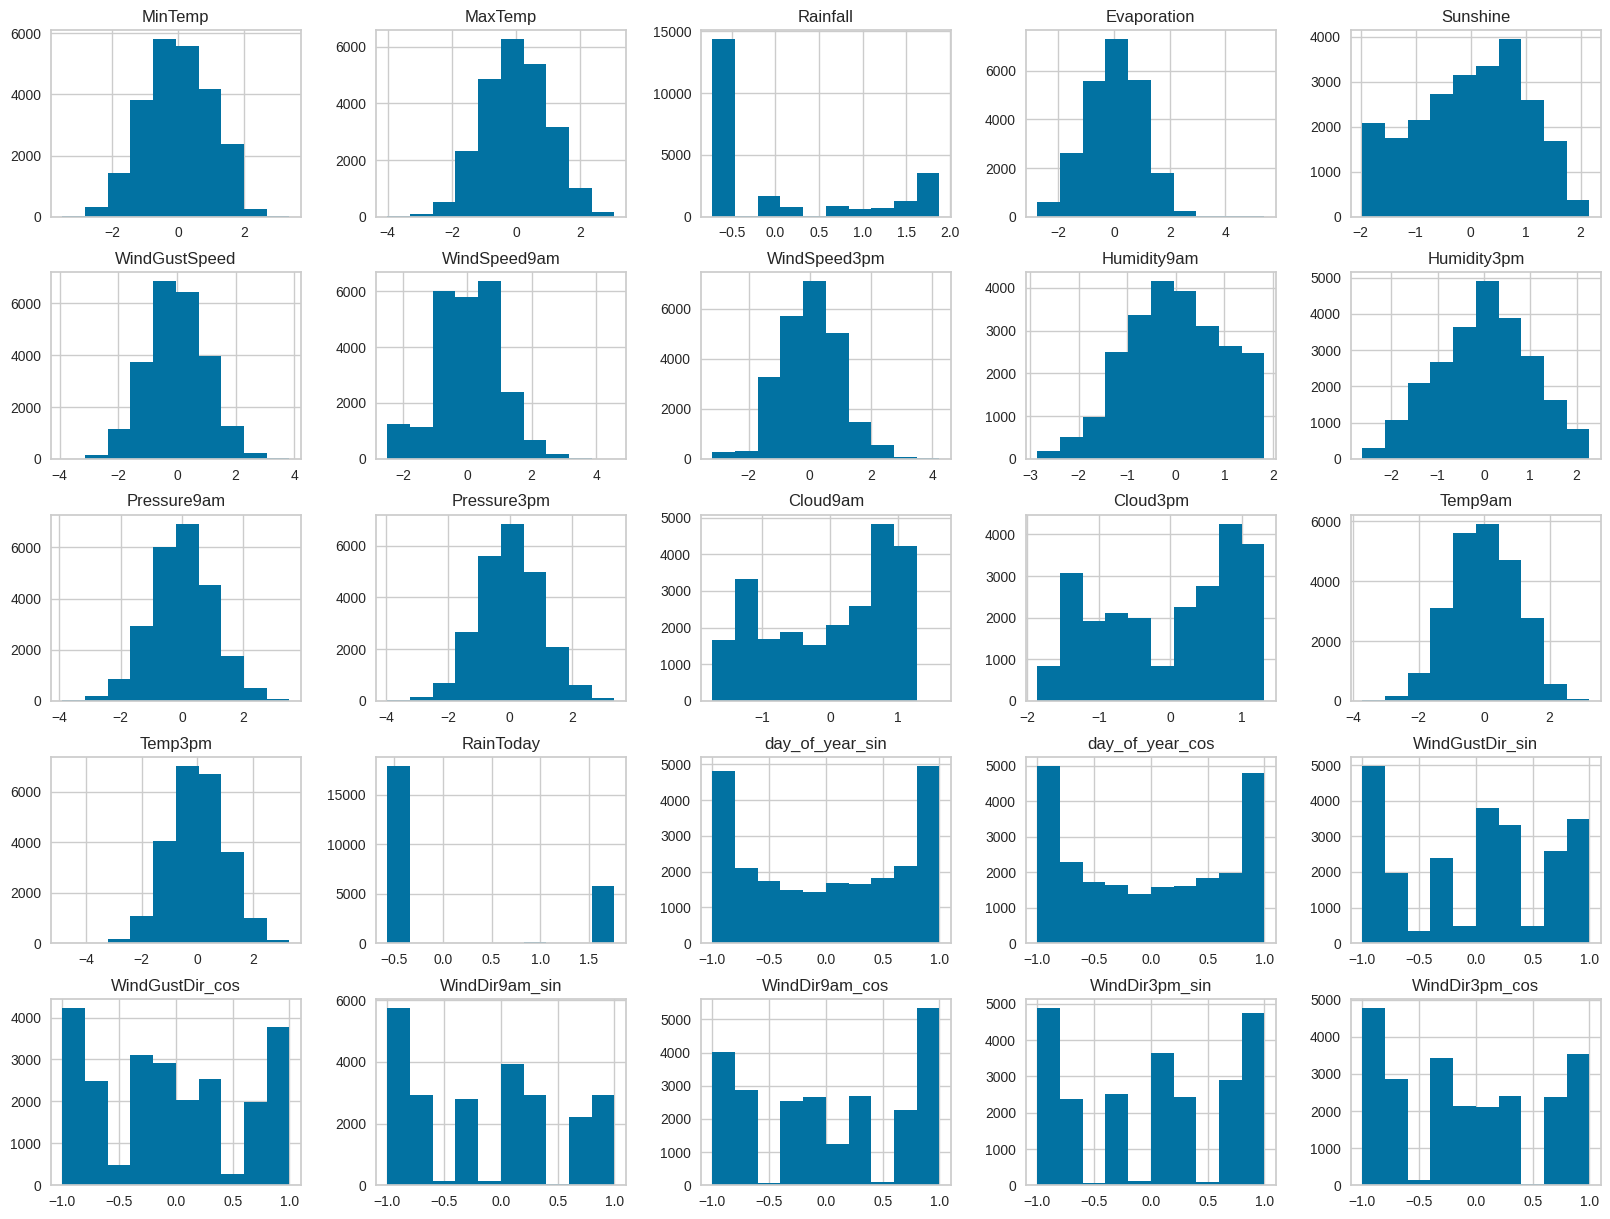

In [44]:
X_train.hist(figsize=(20, 15))
plt.show()

# 2. Implementar la solución del problema de clasificación con regresión logística.
* Obtener las métricas adecuadas (accuracy, precision, recall, F1 score, entre otras, ¡investiguen adicionales!). Graficar matrices de confusión para cada modelo. Analizar “falsos negativos” y “falsos positivos”, ¿qué significa cada uno?

* Trazar curvas ROC para cada modelo. Comenten cuáles serían los umbrales adecuados a utilizar; ¿cómo podrían calcular el mejor umbral? ¿Es 0.5 el mejor?

* ¿Creen que han conseguido un buen fitting?


* Verdaderos Positivos (TP): Casos en los que el modelo predijo correctamente que llovía.
* Falsos Negativos (FN): Casos en los que el modelo predijo que no llovía, pero en realidad sí llovió. El modelo no detectó la lluvia.
* Falsos Positivos (FP): Casos en los que el modelo predijo que llovía, pero en realidad no llovió.
* Verdaderos Negativos (TN): Casos en los que el modelo predijo correctamente que no llovía.

Dado que en nuestro análisis no hay una clase que sea más relevante que la otra es decir, que tanto predecir que llueve como predecir que no llueve tiene implicaciones similares.

Muestra prioridad es optimizar el rendimiento del modelo para que maximice los verdaderos positivos (TP), es decir, queremos asegurarnos de que, en la mayor medida posible, detectemos correctamente los casos en que llueve.

Por lo que queremos minimizar los FP y FN por lo que elegimos F1 Score.

El F1 Score se utiliza cuando los Falsos Negativos (False Negatives) y los Falsos Positivos (False Positives) son importantes. Y es una muy buena métrica para datos desbalanceados.

In [132]:
logreg = LogisticRegression(class_weight='balanced')

In [133]:
# Entrenamos un modelo de regresion logistica.
logreg.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = logreg.predict(X_test)

In [134]:
f1_score_logreg = f1_score(y_test, y_pred)
confusion_matrix_logreg = confusion_matrix(y_test, y_pred)
classification_report_logreg = classification_report(y_test, y_pred)

print(f'f1 Score: {f1_score_logreg} \n')
print(f'Confusion Matrix:\n{confusion_matrix_logreg} \n')
print(f'Classification Report:\n{classification_report_logreg} \n')

f1 Score: 0.6220403390821397 

Confusion Matrix:
[[3596  997]
 [ 296 1064]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.78      0.85      4593
           1       0.52      0.78      0.62      1360

    accuracy                           0.78      5953
   macro avg       0.72      0.78      0.73      5953
weighted avg       0.83      0.78      0.80      5953
 



In [135]:
# Obtengo las probabilidades de predicción del modelo
y_probs = logreg.predict_proba(X_test)[:, 1]

# Calculo la ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

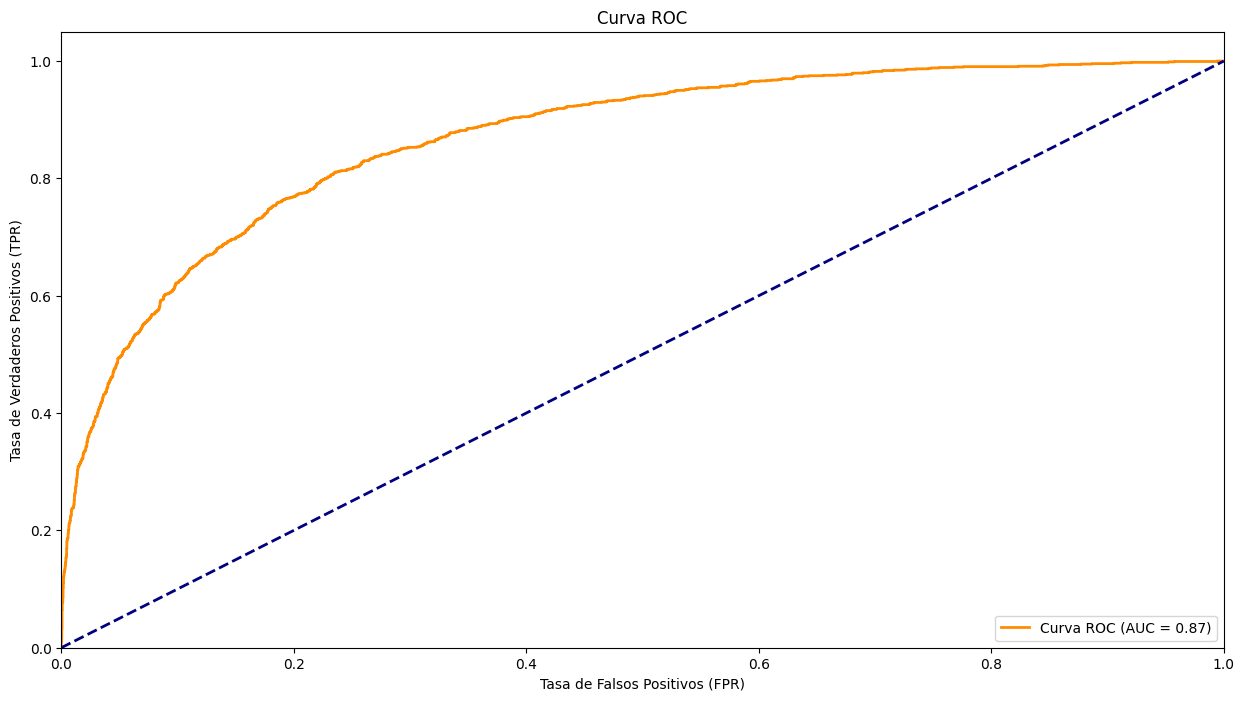

In [136]:
# Grafico la curva ROC
plt.figure(figsize=(15, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

Se calcula el umbral optimo usando el punto mas cercano al (0,1)

In [137]:
optimal_idx = np.argmax(tpr - fpr)
best_threshold = thresholds[optimal_idx]
best_threshold

0.47289645602436

In [138]:
optimal_threshold = best_threshold

# Aplica el umbral óptimo para hacer predicciones
y_pred_optimal = (y_probs >= optimal_threshold).astype(int)

f1_score_logreg = f1_score(y_test, y_pred_optimal)

confusion_matrix_logreg = confusion_matrix(y_test, y_pred_optimal)

classification_report_logreg = classification_report(y_test, y_pred_optimal)

print(f'f1 Score: {f1_score_logreg} \n')
print(f'Confusion Matrix:\n{confusion_matrix_logreg} \n')
print(f'Classification Report:\n{classification_report_logreg} \n')

f1 Score: 0.6223855285472019 

Confusion Matrix:
[[3516 1077]
 [ 259 1101]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.77      0.84      4593
           1       0.51      0.81      0.62      1360

    accuracy                           0.78      5953
   macro avg       0.72      0.79      0.73      5953
weighted avg       0.83      0.78      0.79      5953
 



Después de ajustar el umbral óptimo, se observó que el F1-score aumentó ligeramente, lo que indica una pequeña mejora en la capacidad del modelo para predecir la lluvia, esto se refleja en que los TP aumentaron un poco.

Sin embargo, también se notó un aumento en los FP, lo que significa que el modelo está clasificando erróneamente más casos como lluvia cuando en realidad no lo son. Por otro lado, los FN disminuyeron ligeramente.

# 3. Implementar un modelo base.


In [139]:
# Elegimos KNN como modelo base
basemodel = KNeighborsClassifier(n_neighbors=7)
basemodel.fit(X_train, y_train)

# Hacer predicciones
y_pred = basemodel.predict(X_test)

In [140]:
f1_score_logreg = f1_score(y_test, y_pred)

confusion_matrix_logreg = confusion_matrix(y_test, y_pred)

classification_report_logreg = classification_report(y_test, y_pred)

print(f'f1 Score: {f1_score_logreg} \n')
print(f'Confusion Matrix:\n{confusion_matrix_logreg} \n')
print(f'Classification Report:\n{classification_report_logreg} \n')

f1 Score: 0.5744500846023689 

Confusion Matrix:
[[4268  325]
 [ 681  679]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89      4593
           1       0.68      0.50      0.57      1360

    accuracy                           0.83      5953
   macro avg       0.77      0.71      0.73      5953
weighted avg       0.82      0.83      0.82      5953
 



# 4. Optimizar la selección de hiperparámetros.
* Probar validación cruzada k-folds, si corresponde.
* Utilizar grid search, random search u optuna. Justificar su uso. Justificar los hiperparámetros que se están optimizando.

La decisión de utilizar GridSearch para la optimización de hiperparámetros se fundamenta en la cantidad limitada de parámetros a ajustar en los modelos que estoy trabajando. En el caso de la regresión logística, los hiperparámetros a optimizar son ```penalty```, ```C``` y, en el caso de ElasticNet, ```l1_ratio```. Además, mantengo configuraciones fijas como ```solver='saga'```, dado el tamaño del dataset, y ```class_weight='balanced'```, ya que se optó por esta estrategia en lugar de oversampling o undersampling.


In [141]:
param_grid_logistic = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.01, 0.1, 1, 5, 7, 10],
    'solver': ['saga'],
    'class_weight': ['balanced'],
    'random_state': [42],
    'l1_ratio': [0, 0.5, 1]
}

In [142]:
logistic = LogisticRegression()

In [ ]:
grid_search_logistic = GridSearchCV(logistic, param_grid_logistic, scoring='f1_weighted', cv=5)
grid_search_logistic.fit(X_train, y_train)

best_logistic_model = grid_search_logistic.best_estimator_

In [144]:
print('Mejores hyperparametros para Regression Logistica:', grid_search_logistic.best_params_)

y_pred = best_logistic_model.predict(X_test)

f1_score_logreg = f1_score(y_test, y_pred)
confusion_matrix_logreg = confusion_matrix(y_test, y_pred)
classification_report_logreg = classification_report(y_test, y_pred)

print(f'f1 Score: {f1_score_logreg} \n')
print(f'Confusion Matrix:\n{confusion_matrix_logreg} \n')
print(f'Classification Report:\n{classification_report_logreg} \n')

Mejores hyperparametros para Regression Logistica: {'C': 1, 'class_weight': 'balanced', 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'random_state': 42, 'solver': 'saga'}
f1 Score: 0.6220403390821397 

Confusion Matrix:
[[3596  997]
 [ 296 1064]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.78      0.85      4593
           1       0.52      0.78      0.62      1360

    accuracy                           0.78      5953
   macro avg       0.72      0.78      0.73      5953
weighted avg       0.83      0.78      0.80      5953
 



# 5. Implementar explicabilidad de los modelos.
* Utilizar SHAP o similar. Implementar al menos dos gráficas a nivel local y dos gráficas a nivel global. ¡Escribir lo que se observa!
* ¿Cuáles son las variables más importantes? ¿Cuáles son las menos?


## SHAP Local

In [ ]:
feature_names = X_train.columns
explainer = shap.Explainer(best_logistic_model, X_train, feature_names=feature_names)
shap_values = explainer(X_test)

El primer gráfico corresponde a una instancia clasificada como clase positiva (lluvia), mientras que el segundo gráfico representa una instancia clasificada como clase negativa.

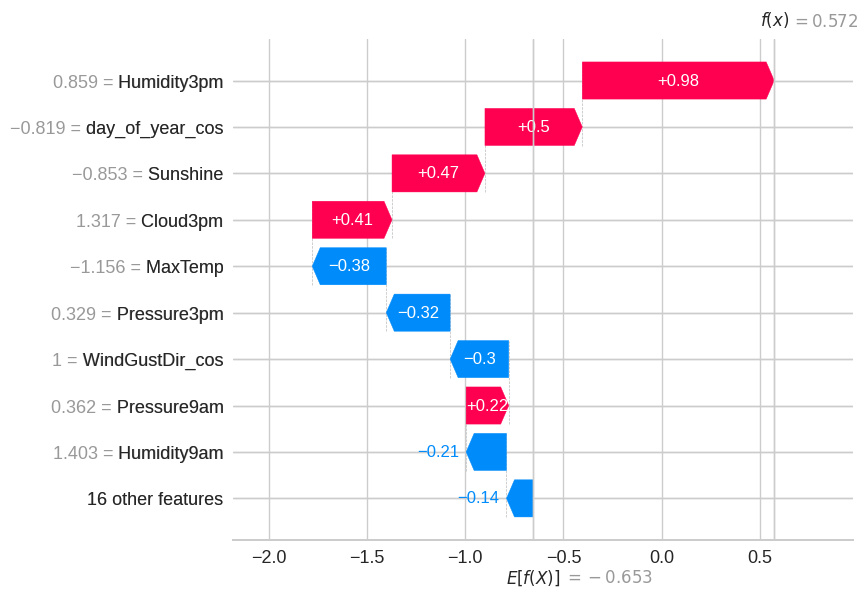

In [ ]:
shap.plots.waterfall(shap_values[5000])

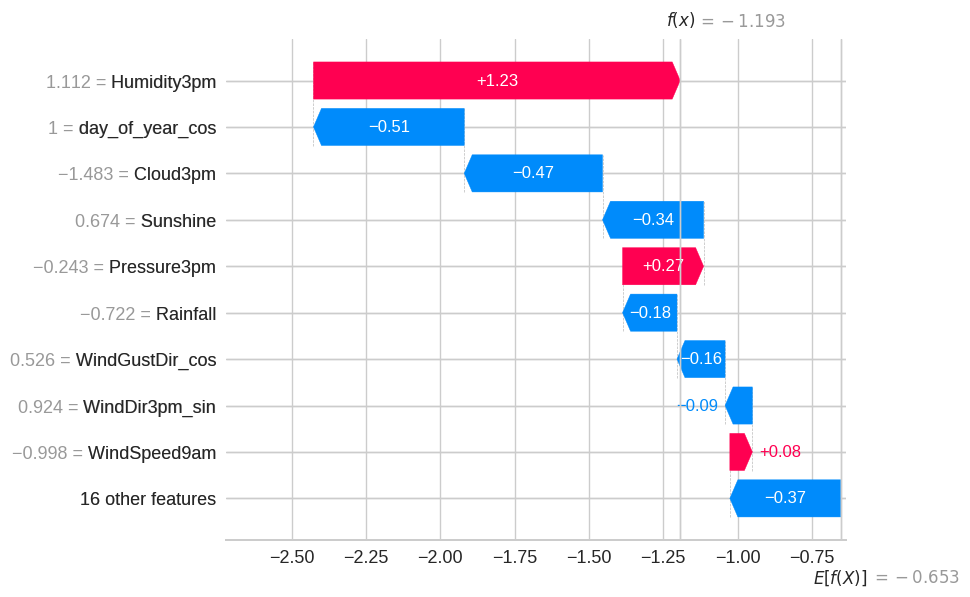

In [ ]:
shap.plots.waterfall(shap_values[50])

Si analizamos las contribuciones de las variables en los dos gráficos, podemos observar lo siguiente:

* **Humidity3pm**: En ambos gráficos, Humidity3pm muestra un impacto positivo considerable. Esto indica que, en general, la humedad por la tarde es un predictor importante, y a mayor valor de esta variable, la probabilidad de lluvia en la predicción tiende a aumentar.

* **day_of_year_cos**: Esta variable tiene un impacto positivo en el primer gráfico, pero negativo en el segundo. Dada la naturaleza cíclica de su codificación, puede representar adecuadamente las épocas del año en las que la probabilidad de lluvia es mayor o menor.

* **Pressure3pm**: En esta variable, parece que a mayor valor, menor es la probabilidad de lluvia, lo que sugiere que las presiones altas a esa hora tienen un efecto negativo en la probabilidad de la lluvia.

* **Sunshine**: Es razonable pensar que, a mayor valor de Sunshine, disminuye la probabilidad de lluvia, y esta relación se mantiene consistente en ambos gráficos.

* **Cloud3pm**: De manera similar, la cantidad de nubes presentes a esa hora sigue la misma lógica: valores más altos de nubes aumentan la probabilidad de lluvia, y viceversa.

También podríamos analizar las variables que resultaron importantes para la predicción, pero solo en uno de los gráficos:

* **MaxTemp**: En esa instancia específica, un valor negativo de la temperatura máxima contribuyó de manera negativa a la predicción de lluvia. Esto podría sugerir la hipótesis de que la lluvia requiere de ciertas temperaturas mínimas para que el agua en estado gaseoso pueda condensarse.

* **Humidity9am**: Contrario a lo que podría indicar el sentido común, un valor positivo de esta variable contribuyó negativamente a la predicción de lluvia. Sería interesante analizar cómo varía la humedad a lo largo del día, ya que un valor alto en Humidity9am podría estar asociado con valores bajos en Humidity3pm, dependiendo de cómo fluctúe la humedad durante el día.

## SHAP Global

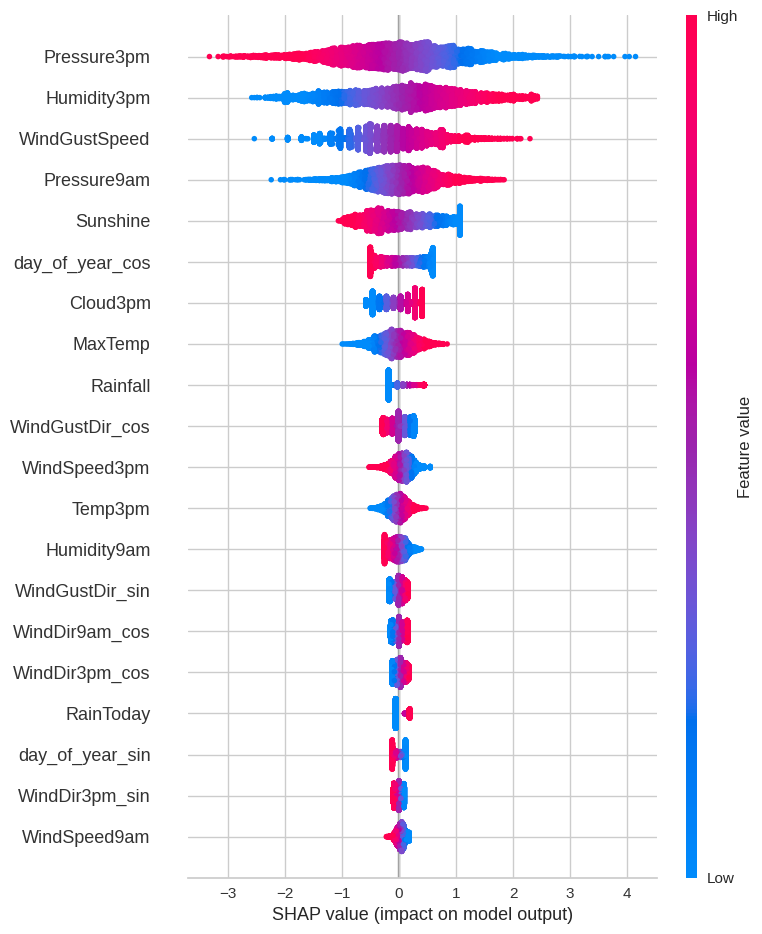

In [ ]:
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

En general todas las conclusiones realizadas a partir de los graficos locales tendieron a reforzarse en este grafico global:

* Habíamos concluido que Humidity3pm tenía un impacto considerable en las predicciones. Observamos que, en general, a mayores valores de esta variable, la probabilidad de lluvia tiende a aumentar. Este comportamiento se ve reflejado y confirmado en el gráfico global de SHAP.

* Pressure3pm mostró una relación inversa, a menores valores de presión, las probabilidades de lluvia aumentan, mientras que valores más altos reducen dichas probabilidades.

* Tambien se corroboraron las conclusiones para Sunshine y Cloud3pm, menos sol y mas nubes aumenta las probabilidades de lluvia logicamente, lo que se ve reflejado en el grafico.

* MaxTemp sigue pareciendo indicar de que se necesita una temperatura mínima para que el agua en estado gaseoso pueda condensarse y generar precipitaciones.

* Para Humidity9am, parece ser que valores bajos de humedad por la mañana están asociados con una mayor probabilidad de lluvia, lo que podría sugerir que la humedad debe ser baja en las primeras horas del día y alta por la tarde para favorecer la precipitación. Este aspecto podría requerir un análisis más detallado para comprender mejor la relación entre la humedad en distintas horas del día y su impacto en la lluvia.

Las observaciones realizadas en los análisis locales tienden a reflejarse en el gráfico global de SHAP, lo que refuerza la validez de las conclusiones. Además, se destaca la importancia de las condiciones atmosféricas a las 3PM (Humidity3pm, Pressure3pm y Cloud3pm), ya que estas variables tienen un impacto significativo en las predicciones. Esto sugiere que esta hora podría ser un punto clave a considerar en futuros análisis o en la recolección de datos.

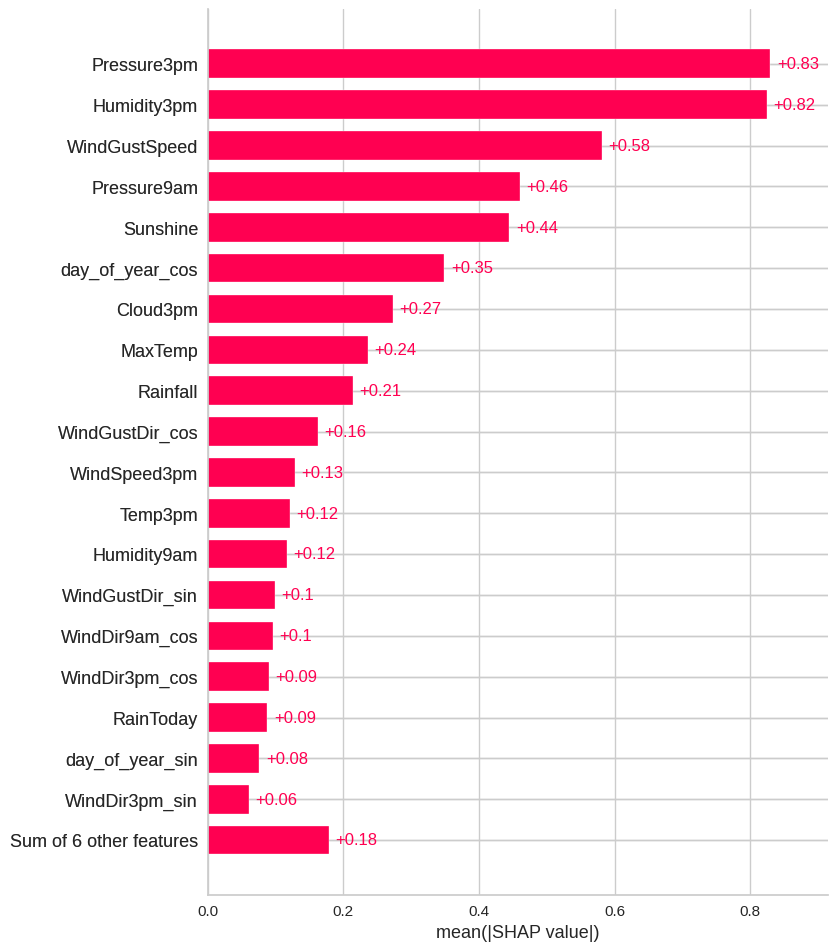

In [ ]:
shap.plots.bar(shap_values, max_display=20)

Un hallazgo significativo que surge del análisis global es la velocidad del viento, una variable que no había aparecido con relevancia en los gráficos locales, pero que aquí se posiciona como la tercera variable más influyente en las predicciones.

Si observamos la distribución de esta variable en el gráfico anterior mayores valores de WindGustSpeed aportan de forma significativa a la prediccion de lluvia, lo cual no había sido identificado en el análisis local.

Este resultado resalta la importancia de analizar tanto las contribuciones locales como las globales, ya que cada perspectiva puede revelar información diferente sobre el impacto de las variables en las predicciones.

# 6. Implementar un modelo de AutoML con scikit-learn. ¿Qué observa?

In [45]:
exp = setup(data=df, target='RainTomorrow', session_id=123, fix_imbalance=True)

best_model = compare_models()
model = create_model(best_model)

Processing:   0%|          | 0/65 [00:00<?, ?it/s]

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Se puede observar que AutoML identificó que el conjunto de datos contiene un 51% de valores faltantes, y categorizó las variables numéricas y categóricas, aplicando un método de imputación simple para las columnas numéricas (promedio) y categóricas (moda). Para las variables categóricas, utilizó la codificación one-hot, que si bien es efectiva, no es tan sofisticada como las estrategias de codificación cíclica que usamos en nuestro trabajo.

Esta simplificación en el preprocesamiento es una ventaja en términos de rapidez, pero también puede ser una desventaja, ya que no considera optimizaciones más complejas que podrían mejorar el rendimiento en ciertos casos.

En cuanto al rendimiento de los modelos, los métodos de ensamblaje, como Extra Trees Classifier y Random Forest Classifier, fueron los más efectivos, destacando Extra Trees Classifier por su alta AUC y F1, y su bajo desvio estándar en los 10 Folds.

Esto refuerza la idea de que los modelos de ensamblaje podrían ser efectivos para resolver este problema, y podrían mejorar aún más con un análisis de preprocesamiento y ajustes más personalizados.

Por otro lado, aunque la Regresión Logística mostró buenos resultados en términos de AUC y precisión, no alcanzó el rendimiento de otros modelos como el Extra Trees en términos de F1, que fue la métrica que se priorizó en este trabajo.

In [46]:
evaluate_model(model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [48]:
predictions = predict_model(model)
predictions

Date    MinTemp    MaxTemp  Rainfall  Evaporation  Sunshine  \
76996   2014-10-07  10.000000  15.100000       3.2          2.4       7.2   
57199   2014-11-26   4.700000  17.799999       0.0          NaN       NaN   
14166   2014-12-29  17.600000  33.099998       3.0          0.4       9.9   
68315   2011-08-20   9.800000  18.500000       0.0          0.8       6.7   
77399   2015-11-14   6.900000  16.600000       3.2          3.4       5.7   
...            ...        ...        ...       ...          ...       ...   
61283   2009-04-12  11.600000  23.600000       0.2          1.8       9.8   
110561  2014-08-11  12.200000  18.200001       0.0          2.0       9.0   
12392   2009-11-22  27.200001  40.200001       0.0         16.0      11.8   
84759   2010-07-23   8.300000  21.500000       0.0          2.8       9.8   
32624   2015-01-12  20.400000  24.400000       9.6          NaN       3.3   

       WindGustDir  WindGustSpeed WindDir9am WindDir3pm  ...  Pressure9am  \
76996          WSW           65.0        WSW          W  ...  1012.900024   
57199          SSW           61.0        SSW        SSW  ...  1021.500000   
14166          WNW           28.0          W         SW  ...  1010.099976   
68315            N           24.0          W        ESE  ...  1031.800049   
77399            S           35.0        SSW        SSW  ...  1020.599976   
...            ...            ...        ...        ...  ...          ...   
61283          WSW           35.0         NW        WSW  ...  1021.799988   
110561         NaN            NaN         NE          E  ...  1032.400024   
12392          NNE           46.0        NNE        WNW  ...  1010.200012   
84759           SE           26.0         SW         SE  ...  1028.300049   
32624            S           56.0        SSE          S  ...  1014.700012   

        Pressure3pm  Cloud9am  Cloud3pm  Temp9am    Temp3pm  RainToday  \
76996   1015.900024       NaN       NaN     11.1  11.900000        Yes   
57199   1021.599976       8.0       8.0     10.7  15.800000         No   
14166   1006.599976       7.0       2.0     22.6  31.000000        Yes   
68315   1030.199951       NaN       NaN     10.7  18.100000         No   
77399   1020.400024       6.0       8.0     13.7  15.400000        Yes   
...             ...       ...       ...      ...        ...        ...   
61283   1019.599976       2.0       1.0     15.1  23.299999         No   
110561  1031.000000       3.0       0.0     14.0  17.299999         No   
12392   1007.799988       7.0       7.0     30.9  39.599998         No   
84759   1025.699951       1.0       3.0     14.7  19.600000         No   
32624   1013.299988       7.0       7.0     22.9  22.900000        Yes   

        RainTomorrow  prediction_label  prediction_score  
76996            Yes               Yes              0.76  
57199             No                No              0.93  
14166             No                No              0.95  
68315             No                No              0.81  
77399             No               Yes              0.60  
...              ...               ...               ...  
61283             No                No              0.86  
110561            No                No              0.91  
12392             No                No              0.87  
84759             No                No              0.91  
32624            Yes               Yes              0.77  

[8929 rows x 24 columns]

# 7. Implementar las soluciones con una red neuronal.
* Obtener las métricas adecuadas. ¿Consigue un mejor fitting que con la regresión logística?
* Repetir los pasos 4 y 5 para las redes neuronales. ¿Qué diferencias observan con los modelos de regresión logística?


## Implementar red neuronal y obtener metricas.

In [ ]:
class NeuralNetworkTensorFlow:

    def __init__(self, learning_rate=0.001, epochs=350):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.model = self.build_model()

    def build_model(self):
        model = Sequential([
            Dense(12, activation='tanh', input_shape=(25,)),
            Dense(12, activation='tanh'),
            Dense(1, activation='sigmoid')
        ])

        model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='binary_crossentropy', metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')])
        print("n° de parámetros:", model.count_params())
        return model

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        history = self.model.fit(X, y, epochs=self.epochs, batch_size=32, verbose=0)
        return history.history

    def predict(self, X):
        X = np.array(X)
        predictions = self.model.predict(X)
        return predictions

Inicialmente, se implementó una red neuronal con dos capas ocultas y una capa de salida. Las dos capas ocultas cuentan con 12 neuronas cada una, lo que fue pensado a priori para probar una configuración intermedia en relación con el tamaño del input.

La función de activación seleccionada para las capas ocultas fue la tangente hiperbólica. Esta elección se basó en que la mayoría de las variables en el dataset, después de ser escaladas y transformadas, presentan distribuciones centradas en 0 con valores entre -4 y 4, o distribuciones bimodales en -1 y 1, en el caso de las funciones trigonométricas. Estos valores negativos son relevantes para la predicción, y se requiere ponderar de igual forma tanto los valores positivos como negativos.

Se consideraron otras funciones de activación como ReLU, que a pesar de no ponderar los valores negativos directamente, al convertirlos a 0, se eligió por su simplicidad y rapidez como una opción inicial. También se contempló ELU, que tiene la capacidad de manejar los valores negativos de manera más eficiente y evitar las neuronas muertas de ReLU.

In [ ]:
nn_tensorflow = NeuralNetworkTensorFlow(learning_rate=0.001, epochs=350)
history = nn_tensorflow.fit(X_train, y_train)
loss_history = history['loss']

n° de parámetros: 481


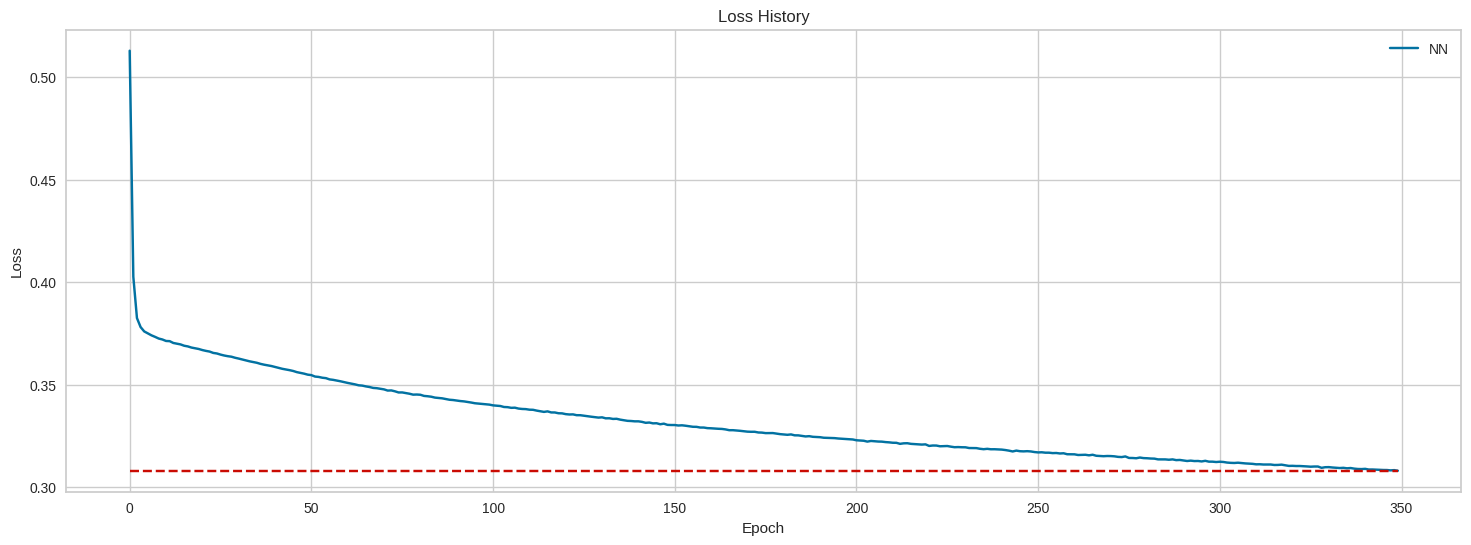

In [ ]:
plt.figure(figsize=(18, 6))
plt.plot(loss_history, label='NN')
plt.hlines(y=np.min(loss_history), xmin=0, xmax=np.argmin(loss_history), color='r', linestyle='--')
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
loss_history[-1]

0.30799710750579834

Se graficó cómo varía la función de pérdida (entropía binaria cruzada) en función de las épocas para la red neuronal. El gráfico muestra el comportamiento hasta las 350 épocas, que fue el límite con el que se entrenó el modelo en esta instancia. Sin embargo, se realizaron pruebas previas con 1000, 600 y 500 épocas.

Al analizar los resultados, se observó que las mejoras más significativas se dieron entre las 300 y las 500 épocas.

Aunque en el caso de 1000 épocas el modelo no mostró signos evidentes de sobreajuste, ya que los errores de entrenamiento y de test eran similares, tampoco mostró aumentos considerables de rendimiento. Por cuestiones de tiempo, se determinó que un número óptimo de épocas para entrenar este modelo es alrededor de las 350. Sin embargo, si se buscara un ajuste más fino, se recomendaría probar con 500 épocas.

In [ ]:
acurracy = history['accuracy']
auc = history['auc']
precision = history['precision']
recall = history['recall']

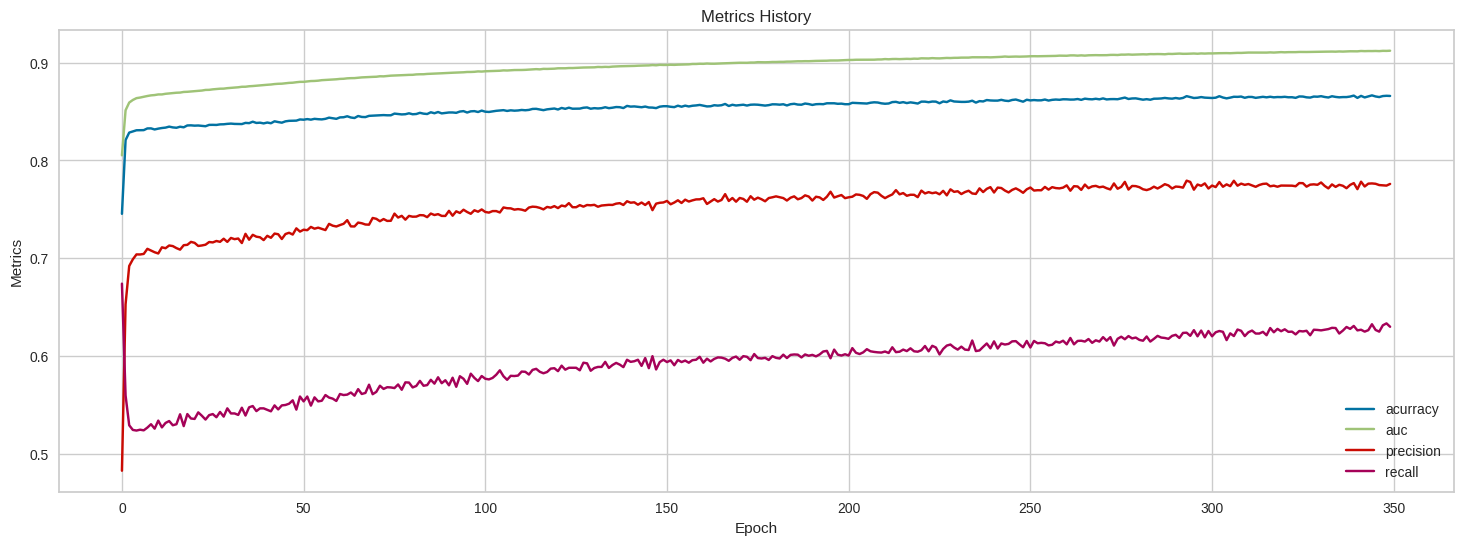

In [ ]:
plt.figure(figsize=(18, 6))
plt.plot(acurracy, label='acurracy')
plt.plot(auc, label='auc')
plt.plot(precision, label='precision')
plt.plot(recall, label='recall')
plt.title('Metrics History')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()
plt.show()

In [ ]:
y_probs = nn_tensorflow.predict(X_test)
threshold = 0.5

y_pred = (y_probs >= threshold).astype(int)

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [ ]:
f1_score_nn = f1_score(y_test, y_pred)
confusion_matrix_nn = confusion_matrix(y_test, y_pred)
classification_report_nn = classification_report(y_test, y_pred)

print(f'f1 Score: {f1_score_nn} \n')
print(f'Confusion Matrix:\n{confusion_matrix_nn} \n')
print(f'Classification Report:\n{classification_report_nn} \n')

f1 Score: 0.6210484193677471 

Confusion Matrix:
[[4230  363]
 [ 584  776]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      4593
           1       0.68      0.57      0.62      1360

    accuracy                           0.84      5953
   macro avg       0.78      0.75      0.76      5953
weighted avg       0.83      0.84      0.84      5953
 



Para esta implementación inicial de la red neuronal, al analizar las métricas obtenidas, se observó un rendimiento similar al obtenido previamente con la regresión logística.

Esto podría deberse a que no se diseñó una arquitectura óptima para la red neuronal, ya sea por la selección del número de neuronas, la cantidad de capas, o la función de activación utilizada.

Se procedió a realizar una optimización de los hiperparámetros con el objetivo de encontrar un modelo más ajustado y que maximice el rendimiento en este problema.

## Optimizacion de hiperparametros

In [148]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [149]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((19048, 25), (4762, 25), (19048,), (4762,))

In [ ]:
def objective(trial):
    # Espacio de hiperparámetros
    n_layers = trial.suggest_int('n_layers', 1, 3)
    n_neurons = trial.suggest_int('n_neurons', 8, 64, step=8)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'elu'])

    # Construcción del modelo
    model = Sequential()
    model.add(Dense(n_neurons, activation=activation, input_shape=(25,)))
    for _ in range(n_layers - 1):
        model.add(Dense(n_neurons, activation=activation))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Entrenamiento
    history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, batch_size=32, verbose=0)

    # Predicciones en el conjunto de validación
    y_pred = (model.predict(X_valid) > 0.5).astype(int)

    # Calculo de precisión y recall
    precision = precision_score(y_valid, y_pred)
    recall = recall_score(y_valid, y_pred)

    # Cálculo del F1-Score
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    return f1

# Ejecuta el estudio
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print('Best hyperparameters:', study.best_params)

[I 2024-11-27 00:38:00,439] A new study created in memory with name: no-name-c35c707a-ddc4-429d-ba80-4c0bac1951b6


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-11-27 00:39:16,387] Trial 0 finished with value: 0.6479637511056323 and parameters: {'n_layers': 3, 'n_neurons': 64, 'learning_rate': 0.00027416301185638215, 'activation': 'elu'}. Best is trial 0 with value: 0.6479637511056323.


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-11-27 00:40:30,945] Trial 1 finished with value: 0.5944055459163752 and parameters: {'n_layers': 2, 'n_neurons': 24, 'learning_rate': 0.007473034959092612, 'activation': 'elu'}. Best is trial 0 with value: 0.6479637511056323.


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-11-27 00:41:40,161] Trial 2 finished with value: 0.6118635656095824 and parameters: {'n_layers': 2, 'n_neurons': 32, 'learning_rate': 0.0008711018299980817, 'activation': 'tanh'}. Best is trial 0 with value: 0.6479637511056323.


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-11-27 00:42:51,249] Trial 3 finished with value: 0.6558098092138642 and parameters: {'n_layers': 1, 'n_neurons': 48, 'learning_rate': 0.0012808818674778654, 'activation': 'tanh'}. Best is trial 3 with value: 0.6558098092138642.


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-11-27 00:44:00,388] Trial 4 finished with value: 0.6245210235841868 and parameters: {'n_layers': 1, 'n_neurons': 32, 'learning_rate': 0.007654545236725016, 'activation': 'relu'}. Best is trial 3 with value: 0.6558098092138642.


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-11-27 00:45:09,167] Trial 5 finished with value: 0.6455171917030028 and parameters: {'n_layers': 2, 'n_neurons': 40, 'learning_rate': 0.001238472963095794, 'activation': 'elu'}. Best is trial 3 with value: 0.6558098092138642.


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-11-27 00:46:23,677] Trial 6 finished with value: 0.5894105409213702 and parameters: {'n_layers': 3, 'n_neurons': 56, 'learning_rate': 0.006723292021532057, 'activation': 'elu'}. Best is trial 3 with value: 0.6558098092138642.


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-11-27 00:47:32,741] Trial 7 finished with value: 0.6378326503032917 and parameters: {'n_layers': 2, 'n_neurons': 56, 'learning_rate': 0.00010545423055095824, 'activation': 'elu'}. Best is trial 3 with value: 0.6558098092138642.


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-11-27 00:48:41,647] Trial 8 finished with value: 0.5986332076525174 and parameters: {'n_layers': 2, 'n_neurons': 56, 'learning_rate': 0.0013088544294476757, 'activation': 'tanh'}. Best is trial 3 with value: 0.6558098092138642.


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-11-27 00:49:48,842] Trial 9 finished with value: 0.6138131805943826 and parameters: {'n_layers': 1, 'n_neurons': 8, 'learning_rate': 0.00043283536192360893, 'activation': 'tanh'}. Best is trial 3 with value: 0.6558098092138642.


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-11-27 00:51:00,200] Trial 10 finished with value: 0.6187383548575272 and parameters: {'n_layers': 1, 'n_neurons': 48, 'learning_rate': 0.003350318447155768, 'activation': 'relu'}. Best is trial 3 with value: 0.6558098092138642.


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-11-27 00:52:13,252] Trial 11 finished with value: 0.6318335261670694 and parameters: {'n_layers': 3, 'n_neurons': 64, 'learning_rate': 0.0002111648861127127, 'activation': 'tanh'}. Best is trial 3 with value: 0.6558098092138642.


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-11-27 00:53:24,562] Trial 12 finished with value: 0.637043916815287 and parameters: {'n_layers': 3, 'n_neurons': 64, 'learning_rate': 0.0004495153188587747, 'activation': 'elu'}. Best is trial 3 with value: 0.6558098092138642.


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-11-27 00:54:38,644] Trial 13 finished with value: 0.6128730847899506 and parameters: {'n_layers': 1, 'n_neurons': 48, 'learning_rate': 0.00245750658225054, 'activation': 'tanh'}. Best is trial 3 with value: 0.6558098092138642.


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-11-27 00:55:52,456] Trial 14 finished with value: 0.6169428600964009 and parameters: {'n_layers': 3, 'n_neurons': 48, 'learning_rate': 0.0004960833907988216, 'activation': 'relu'}. Best is trial 3 with value: 0.6558098092138642.


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-11-27 00:57:11,879] Trial 15 finished with value: 0.6411928675068155 and parameters: {'n_layers': 3, 'n_neurons': 64, 'learning_rate': 0.00020142368560660363, 'activation': 'elu'}. Best is trial 3 with value: 0.6558098092138642.


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-11-27 00:58:21,900] Trial 16 finished with value: 0.6076320450540689 and parameters: {'n_layers': 1, 'n_neurons': 16, 'learning_rate': 0.002610494943106101, 'activation': 'tanh'}. Best is trial 3 with value: 0.6558098092138642.


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-11-27 00:59:35,048] Trial 17 finished with value: 0.6150212071007197 and parameters: {'n_layers': 2, 'n_neurons': 40, 'learning_rate': 0.0007160236829367792, 'activation': 'tanh'}. Best is trial 3 with value: 0.6558098092138642.


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-11-27 01:00:47,302] Trial 18 finished with value: 0.6463244996108891 and parameters: {'n_layers': 1, 'n_neurons': 56, 'learning_rate': 0.00024050661327213458, 'activation': 'elu'}. Best is trial 3 with value: 0.6558098092138642.


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-11-27 01:02:00,084] Trial 19 finished with value: 0.5975031785904868 and parameters: {'n_layers': 3, 'n_neurons': 48, 'learning_rate': 0.0016671041035851363, 'activation': 'relu'}. Best is trial 3 with value: 0.6558098092138642.


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-11-27 01:03:11,785] Trial 20 finished with value: 0.6354417664554889 and parameters: {'n_layers': 2, 'n_neurons': 64, 'learning_rate': 0.0001222830237528983, 'activation': 'elu'}. Best is trial 3 with value: 0.6558098092138642.


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-11-27 01:04:20,281] Trial 21 finished with value: 0.6405727431035404 and parameters: {'n_layers': 1, 'n_neurons': 56, 'learning_rate': 0.0002672327829826091, 'activation': 'elu'}. Best is trial 3 with value: 0.6558098092138642.


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-11-27 01:05:31,707] Trial 22 finished with value: 0.6358381011600177 and parameters: {'n_layers': 1, 'n_neurons': 56, 'learning_rate': 0.00030436908201403524, 'activation': 'elu'}. Best is trial 3 with value: 0.6558098092138642.


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-11-27 01:06:42,890] Trial 23 finished with value: 0.6401111129665896 and parameters: {'n_layers': 1, 'n_neurons': 40, 'learning_rate': 0.0007633886500138486, 'activation': 'elu'}. Best is trial 3 with value: 0.6558098092138642.


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-11-27 01:07:51,079] Trial 24 finished with value: 0.6371428078514778 and parameters: {'n_layers': 1, 'n_neurons': 48, 'learning_rate': 0.000534467164464159, 'activation': 'elu'}. Best is trial 3 with value: 0.6558098092138642.


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-11-27 01:09:03,094] Trial 25 finished with value: 0.6232376758564708 and parameters: {'n_layers': 1, 'n_neurons': 64, 'learning_rate': 0.0001628260128401927, 'activation': 'tanh'}. Best is trial 3 with value: 0.6558098092138642.


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-11-27 01:10:15,518] Trial 26 finished with value: 0.6503914749829296 and parameters: {'n_layers': 2, 'n_neurons': 56, 'learning_rate': 0.0003806141922197107, 'activation': 'elu'}. Best is trial 3 with value: 0.6558098092138642.


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-11-27 01:11:25,886] Trial 27 finished with value: 0.6423561917207596 and parameters: {'n_layers': 2, 'n_neurons': 40, 'learning_rate': 0.00035687543702715664, 'activation': 'elu'}. Best is trial 3 with value: 0.6558098092138642.


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-11-27 01:12:46,800] Trial 28 finished with value: 0.5788256554130163 and parameters: {'n_layers': 3, 'n_neurons': 64, 'learning_rate': 0.0006641200585269988, 'activation': 'relu'}. Best is trial 3 with value: 0.6558098092138642.


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-11-27 01:14:02,076] Trial 29 finished with value: 0.6393442131805492 and parameters: {'n_layers': 2, 'n_neurons': 32, 'learning_rate': 0.00014935823372282128, 'activation': 'tanh'}. Best is trial 3 with value: 0.6558098092138642.


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-11-27 01:15:12,080] Trial 30 finished with value: 0.6178107110727405 and parameters: {'n_layers': 2, 'n_neurons': 48, 'learning_rate': 0.0011155327784408051, 'activation': 'elu'}. Best is trial 3 with value: 0.6558098092138642.


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-11-27 01:16:25,301] Trial 31 finished with value: 0.6379146425900175 and parameters: {'n_layers': 1, 'n_neurons': 56, 'learning_rate': 0.00025209077629609263, 'activation': 'elu'}. Best is trial 3 with value: 0.6558098092138642.


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-11-27 01:17:37,288] Trial 32 finished with value: 0.6394051548842387 and parameters: {'n_layers': 2, 'n_neurons': 56, 'learning_rate': 0.00036264549690090197, 'activation': 'elu'}. Best is trial 3 with value: 0.6558098092138642.


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-11-27 01:18:48,310] Trial 33 finished with value: 0.6381765888478126 and parameters: {'n_layers': 1, 'n_neurons': 56, 'learning_rate': 0.00018388487825358988, 'activation': 'elu'}. Best is trial 3 with value: 0.6558098092138642.


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-11-27 01:19:58,731] Trial 34 finished with value: 0.6331521241198463 and parameters: {'n_layers': 2, 'n_neurons': 24, 'learning_rate': 0.0015912945408483217, 'activation': 'elu'}. Best is trial 3 with value: 0.6558098092138642.


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-11-27 01:21:11,350] Trial 35 finished with value: 0.6393161893171564 and parameters: {'n_layers': 3, 'n_neurons': 64, 'learning_rate': 0.001011256711060139, 'activation': 'elu'}. Best is trial 3 with value: 0.6558098092138642.


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-11-27 01:22:24,248] Trial 36 finished with value: 0.6412992543537164 and parameters: {'n_layers': 2, 'n_neurons': 56, 'learning_rate': 0.0005948705301474128, 'activation': 'elu'}. Best is trial 3 with value: 0.6558098092138642.


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-11-27 01:23:36,108] Trial 37 finished with value: 0.6257335844972497 and parameters: {'n_layers': 1, 'n_neurons': 48, 'learning_rate': 0.005254197245177371, 'activation': 'tanh'}. Best is trial 3 with value: 0.6558098092138642.


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-11-27 01:24:45,950] Trial 38 finished with value: 0.6320891414669647 and parameters: {'n_layers': 1, 'n_neurons': 56, 'learning_rate': 0.00032746088485615006, 'activation': 'elu'}. Best is trial 3 with value: 0.6558098092138642.


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-11-27 01:25:59,263] Trial 39 finished with value: 0.6355851076893413 and parameters: {'n_layers': 3, 'n_neurons': 32, 'learning_rate': 0.00010282490322811726, 'activation': 'relu'}. Best is trial 3 with value: 0.6558098092138642.


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-11-27 01:27:09,774] Trial 40 finished with value: 0.6026241304560295 and parameters: {'n_layers': 2, 'n_neurons': 40, 'learning_rate': 0.0009102346590709538, 'activation': 'tanh'}. Best is trial 3 with value: 0.6558098092138642.


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-11-27 01:28:20,695] Trial 41 finished with value: 0.6438595991699407 and parameters: {'n_layers': 2, 'n_neurons': 40, 'learning_rate': 0.0014584501572777087, 'activation': 'elu'}. Best is trial 3 with value: 0.6558098092138642.


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-11-27 01:29:30,517] Trial 42 finished with value: 0.6251754301410949 and parameters: {'n_layers': 2, 'n_neurons': 48, 'learning_rate': 0.002121903551894319, 'activation': 'elu'}. Best is trial 3 with value: 0.6558098092138642.


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-11-27 01:30:38,956] Trial 43 finished with value: 0.619877482366273 and parameters: {'n_layers': 2, 'n_neurons': 56, 'learning_rate': 0.0012642090222122915, 'activation': 'elu'}. Best is trial 3 with value: 0.6558098092138642.


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-11-27 01:31:50,428] Trial 44 finished with value: 0.6075696725659651 and parameters: {'n_layers': 2, 'n_neurons': 24, 'learning_rate': 0.0037120486130537513, 'activation': 'elu'}. Best is trial 3 with value: 0.6558098092138642.


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-11-27 01:33:02,185] Trial 45 finished with value: 0.6380951888038587 and parameters: {'n_layers': 1, 'n_neurons': 48, 'learning_rate': 0.00023215135694971205, 'activation': 'elu'}. Best is trial 3 with value: 0.6558098092138642.


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-11-27 01:34:16,547] Trial 46 finished with value: 0.5980819029504629 and parameters: {'n_layers': 2, 'n_neurons': 64, 'learning_rate': 0.0020781925588856903, 'activation': 'tanh'}. Best is trial 3 with value: 0.6558098092138642.


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-11-27 01:35:37,820] Trial 47 finished with value: 0.6381909047865343 and parameters: {'n_layers': 3, 'n_neurons': 40, 'learning_rate': 0.00042424318192172154, 'activation': 'relu'}. Best is trial 3 with value: 0.6558098092138642.


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-11-27 01:36:51,771] Trial 48 finished with value: 0.570252139533052 and parameters: {'n_layers': 2, 'n_neurons': 56, 'learning_rate': 0.009582643421721477, 'activation': 'elu'}. Best is trial 3 with value: 0.6558098092138642.


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-11-27 01:38:07,798] Trial 49 finished with value: 0.6393743753507026 and parameters: {'n_layers': 3, 'n_neurons': 48, 'learning_rate': 0.00013466321880770325, 'activation': 'tanh'}. Best is trial 3 with value: 0.6558098092138642.


Best hyperparameters: {'n_layers': 1, 'n_neurons': 48, 'learning_rate': 0.0012808818674778654, 'activation': 'tanh'}


In [ ]:
# Best hyperparameters: {'n_layers': 1, 'n_neurons': 48, 'learning_rate': 0.0012808818674778654, 'activation': 'tanh'} F1 0.6558098092138642

El optimizador seleccionado para este modelo fue Optuna, debido a su eficiencia para manejar la gran cantidad de parámetros que requiere una red neuronal.

Se variaron el número de capas ocultas entre 1 y 3, el número de neuronas por capa entre 8 y 64, el learning rate se ajustó entre dos valores bajos, y las funciones de activación probadas fueron ReLU, tangente hiperbólica y ELU.

La métrica elegida para optimizar fue F1, dado que se busca maximizar la predicción correcta de la lluvia, como se justificó previamente.

Por cuestiones de tiempo, la cantidad de épocas para cada modelo se limitó a 50. Si bien esto podría resultar en modelos poco entrenados, esta configuración fue suficiente para obtener buenas métricas, por lo que se consideró adecuada para este análisis.

## Metricas del mejor modelo.

In [150]:
class NeuralNetworkTensorFlow:

    def __init__(self, learning_rate=0.001, epochs=350):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.model = self.build_model()

    def build_model(self):
        model = Sequential([
            Dense(48, activation='tanh', input_shape=(25,)),
            Dense(1, activation='sigmoid')
        ])

        model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='binary_crossentropy', metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')])
        print("n° de parámetros:", model.count_params())
        return model

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        history = self.model.fit(X, y, epochs=self.epochs, batch_size=32, verbose=0)
        return history.history

    def predict(self, X):
        X = np.array(X)
        predictions = self.model.predict(X)
        return predictions

In [151]:
nn_tensorflow = NeuralNetworkTensorFlow(learning_rate=0.00021665975986665252, epochs=350)
history = nn_tensorflow.fit(X_train, y_train)
loss_history = history['loss']

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


n° de parámetros: 1297


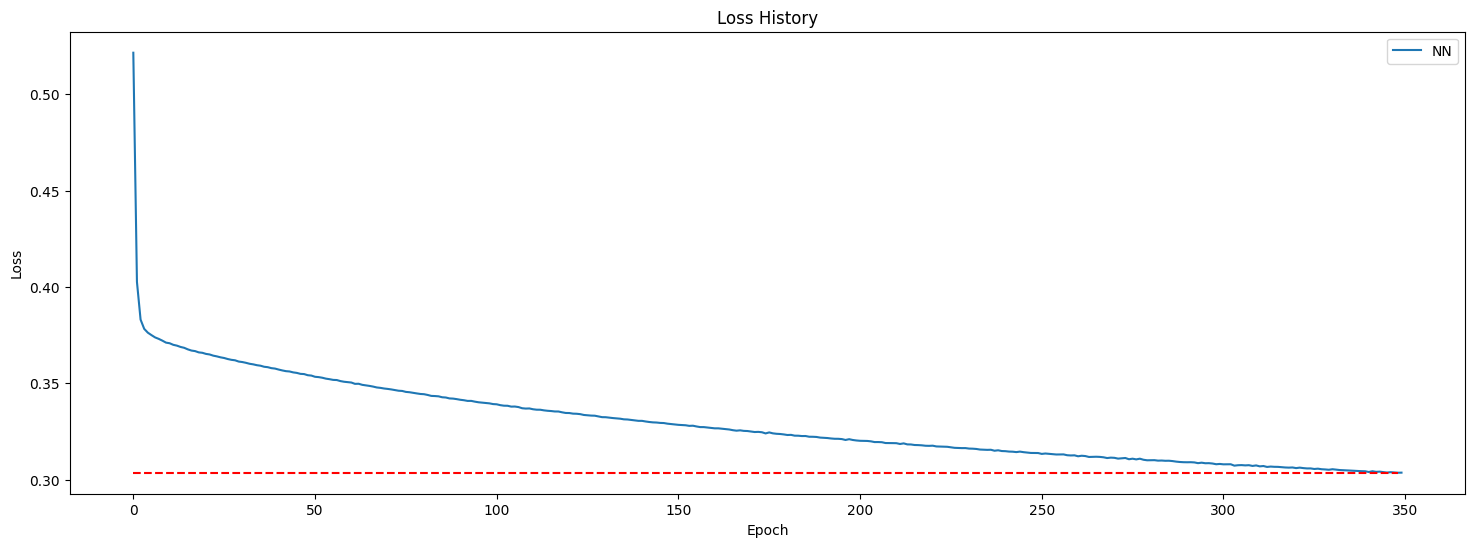

In [152]:
plt.figure(figsize=(18, 6))
plt.plot(loss_history, label='NN')
plt.hlines(y=np.min(loss_history), xmin=0, xmax=np.argmin(loss_history), color='r', linestyle='--')
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [153]:
loss_history[-1]

0.3036862909793854

In [154]:
acurracy = history['accuracy']
auc = history['auc']
precision = history['precision']
recall = history['recall']

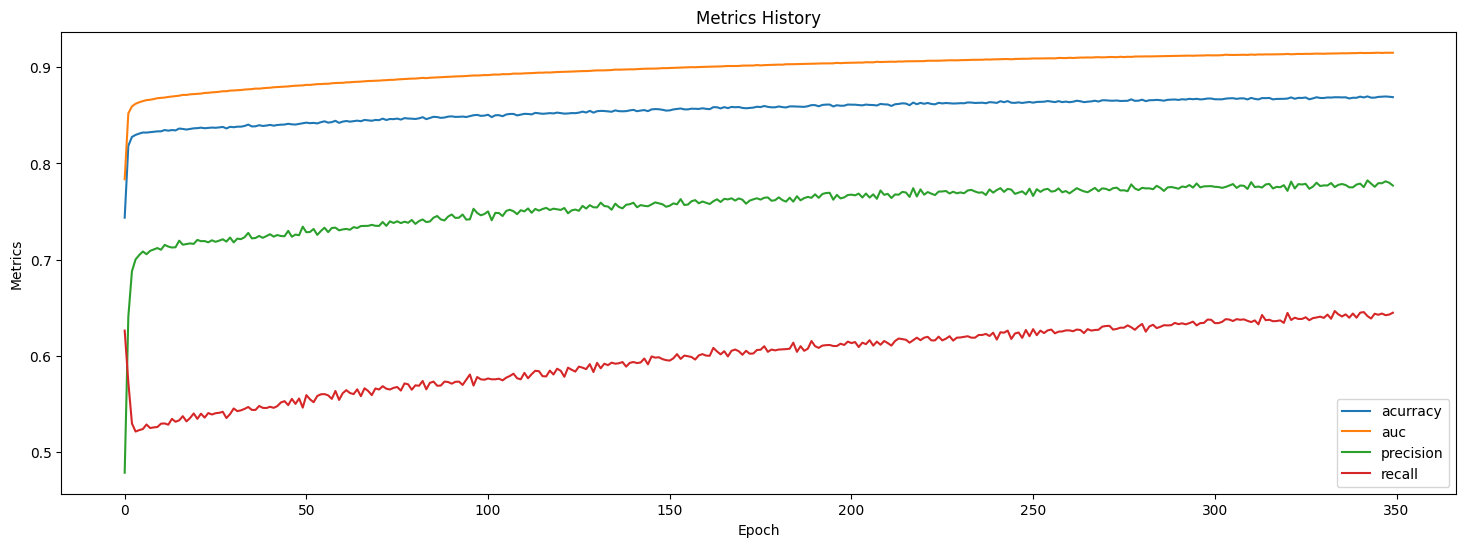

In [155]:
plt.figure(figsize=(18, 6))
plt.plot(acurracy, label='acurracy')
plt.plot(auc, label='auc')
plt.plot(precision, label='precision')
plt.plot(recall, label='recall')
plt.title('Metrics History')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()
plt.show()

In [156]:
threshold = 0.5
y_probs = nn_tensorflow.predict(X_test)
y_pred = (y_probs >= threshold).astype(int)

y_train_probs = nn_tensorflow.predict(X_train)
y_train_pred = (y_train_probs >= threshold).astype(int)

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
596/596 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [157]:
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Train accuracy: {train_accuracy} \nTest accuracy: {test_accuracy}\n')

f1_score_nn = f1_score(y_test, y_pred)
confusion_matrix_nn = confusion_matrix(y_test, y_pred)
classification_report_nn = classification_report(y_test, y_pred)

print(f'f1 Score: {f1_score_nn} \n')
print(f'Confusion Matrix:\n{confusion_matrix_nn} \n')
print(f'Classification Report:\n{classification_report_nn} \n')

Train accuracy: 0.870590088198236 
Test accuracy: 0.8431043171510163

f1 Score: 0.6354410616705699 

Confusion Matrix:
[[4205  388]
 [ 546  814]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      4593
           1       0.68      0.60      0.64      1360

    accuracy                           0.84      5953
   macro avg       0.78      0.76      0.77      5953
weighted avg       0.84      0.84      0.84      5953
 



Analizando las métricas del mejor modelo encontrado, se observa que la accuracy en train fue de 0.87 y en test de 0.84, lo cual es un buen indicio para descartar overfitting.

Además, la métrica F1 Score aumentó a 0.63, lo que representa una mejora significativa en comparación con el modelo inicial, dado que el objetivo principal es predecir correctamente la lluvia.

## Implementar explicabilidad del modelo.

### SHAP Local

In [ ]:
feature_names = X_train.columns

model = nn_tensorflow.model
explainer = shap.Explainer(model, X_train, feature_names=feature_names)
shap_values = explainer(X_test)

PermutationExplainer explainer: 5954it [08:17, 11.73it/s]


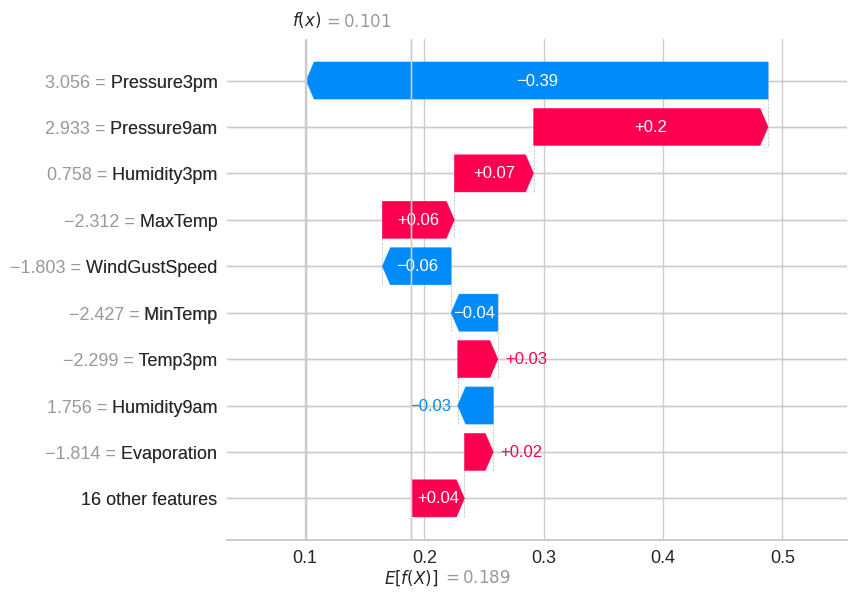

In [ ]:
shap.plots.waterfall(shap_values[728])

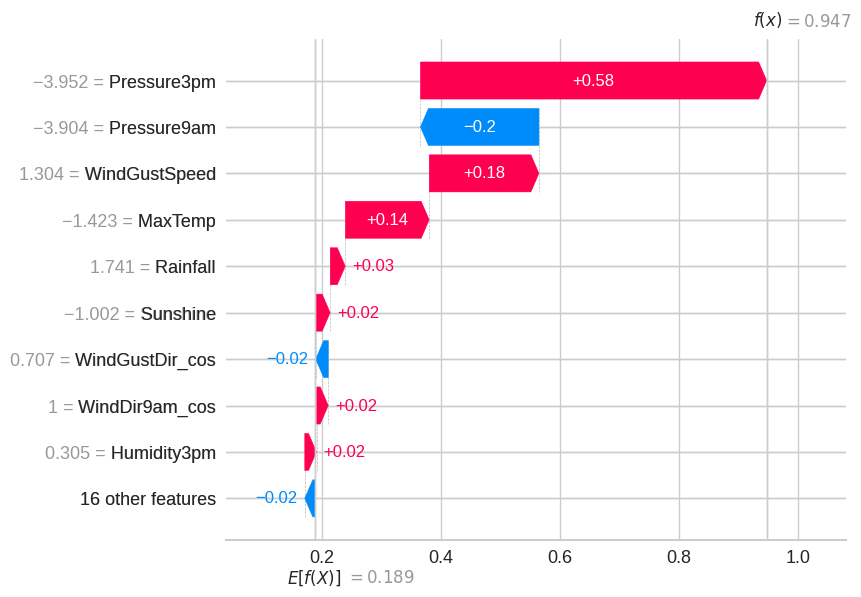

In [ ]:
shap.plots.waterfall(shap_values[4199])

Al observar los gráficos SHAP de la red neuronal en comparación con los de la regresión logística, podemos apreciar que para valores similares de las variables, los modelos ponderan de manera diferente.

En particular, en la red neuronal, valores más grandes para una variable no necesariamente se traducen en aportaciones más grandes, lo cual se debe a que la red neuronal es capaz de capturar relaciones no lineales entre las variables.

Además, las contribuciones de las variables en la red neuronal tienden a ser más pequeñas en comparación con la regresión logística, lo que sugiere que el modelo está realizando un ajuste más fino en las predicciones.

### SHAP Global

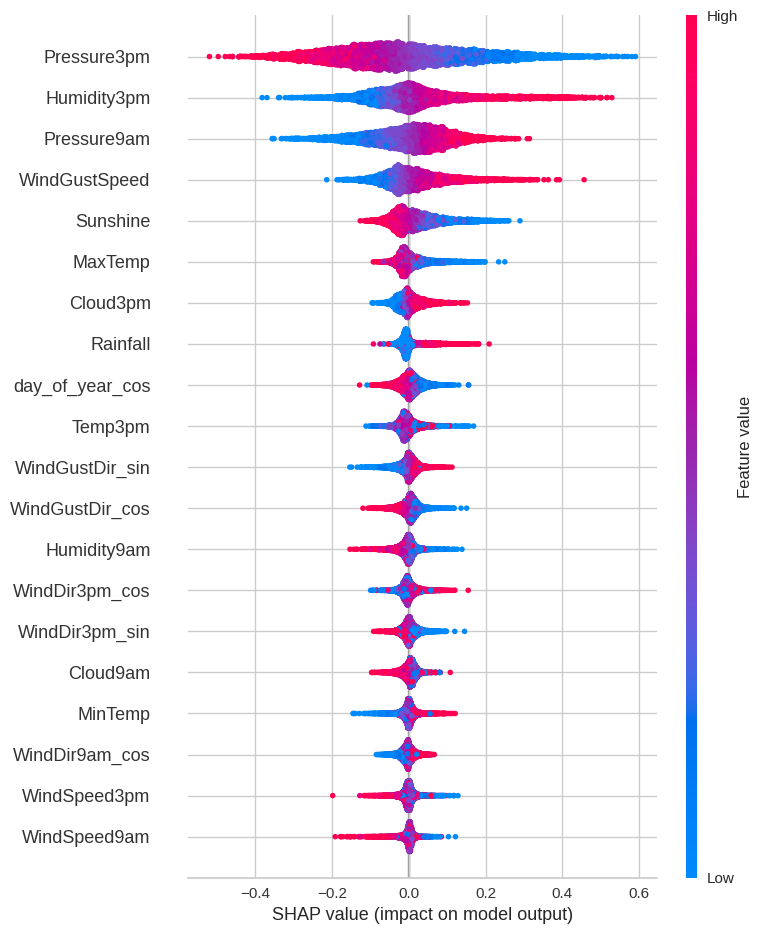

In [ ]:
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

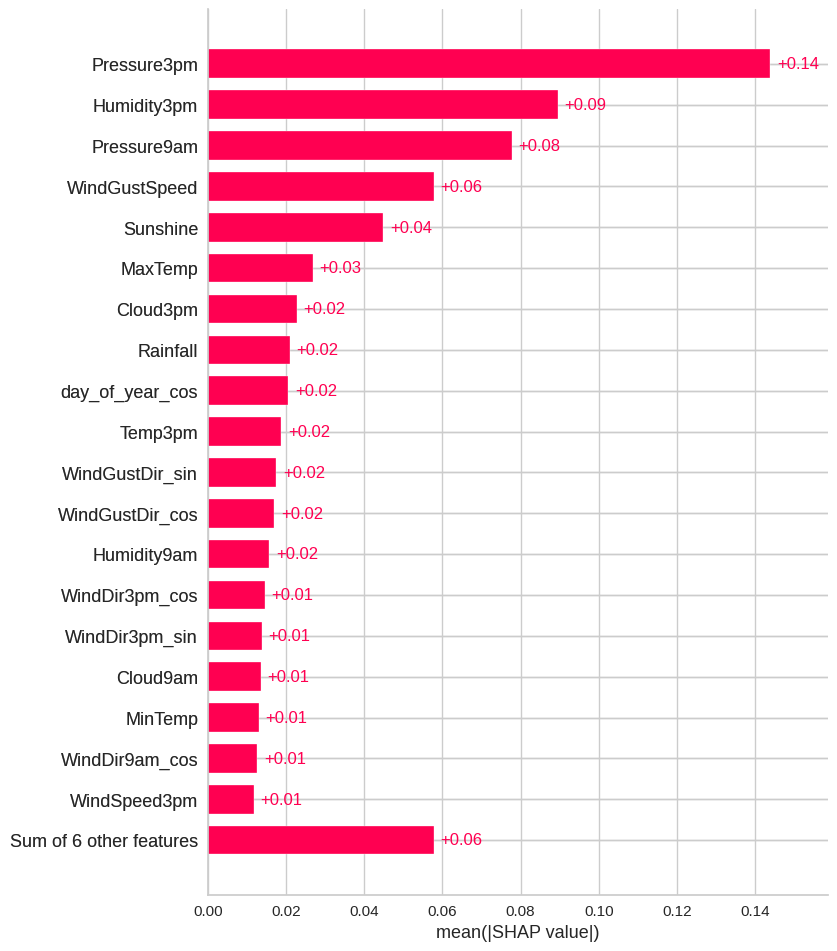

In [ ]:
shap.plots.bar(shap_values, max_display=20)

Al observar los gráficos SHAP globales, se puede apreciar que las contribuciones de las variables al modelo de la red neuronal son notablemente más pequeñas en comparación con la regresión logística. Los valores de SHAP para las variables en el modelo de red neuronal oscilan entre aproximadamente -0.6 y 0.6, mientras que en la regresión logística los valores son mucho más altos con un rango de -4 a 4.

Nuevamente esto sugiere que la red neuronal realiza ajustes más finos en sus predicciones, lo que podría indicar un enfoque más delicado y matizado en la ponderación de cada variable.

Además, a diferencia de la regresión logística, donde las contribuciones de las variables siguen un patrón más lineal y predecible (gradiente de high a low), los gráficos SHAP globales de la red neuronal muestran un patrón más ruidoso.

En estos gráficos, las contribuciones de las variables no siguen una progresión perfecta de "high a low", sino que hay un comportamiento más errático, especialmente en las áreas centrales, donde se observa una mezcla de puntos rojos y azules.

Este "ruido" observado en los gráficos indica que la red neuronal está considerando el contexto de las variables combinadas para cada instancia, lo que le permite hacer ajustes más finos en sus predicciones. Es decir, la red neuronal no solo aumenta o disminuye el valor de SHAP de forma abrupta con base en una variable de alto o bajo valor, sino que ajusta la contribución de cada variable en función de la interacción con otras variables.



# 8. Comparación de modelos.
* Incluyan en su análisis una comparación de todos los modelos de clasificación, ¿cuál es el mejor? Escoger UNA métrica adecuada para poder compararlos.

### Regresion Logisitica

In [158]:
y_pred = best_logistic_model.predict(X_test)

f1_score_logreg = f1_score(y_test, y_pred)
confusion_matrix_logreg = confusion_matrix(y_test, y_pred)
classification_report_logreg = classification_report(y_test, y_pred)

print(f'f1 Score: {f1_score_logreg} \n')
print(f'Confusion Matrix:\n{confusion_matrix_logreg} \n')
print(f'Classification Report:\n{classification_report_logreg} \n')

f1 Score: 0.6220403390821397 

Confusion Matrix:
[[3596  997]
 [ 296 1064]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.78      0.85      4593
           1       0.52      0.78      0.62      1360

    accuracy                           0.78      5953
   macro avg       0.72      0.78      0.73      5953
weighted avg       0.83      0.78      0.80      5953
 



### Red Neuronal

In [160]:
threshold = 0.5
y_probs = nn_tensorflow.predict(X_test)
y_pred = (y_probs >= threshold).astype(int)

y_train_probs = nn_tensorflow.predict(X_train)
y_train_pred = (y_train_probs >= threshold).astype(int)

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
596/596 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [161]:
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Train accuracy: {train_accuracy} \nTest accuracy: {test_accuracy}\n')

f1_score_nn = f1_score(y_test, y_pred)
confusion_matrix_nn = confusion_matrix(y_test, y_pred)
classification_report_nn = classification_report(y_test, y_pred)

print(f'f1 Score: {f1_score_nn} \n')
print(f'Confusion Matrix:\n{confusion_matrix_nn} \n')
print(f'Classification Report:\n{classification_report_nn} \n')

Train accuracy: 0.870590088198236 
Test accuracy: 0.8431043171510163

f1 Score: 0.6354410616705699 

Confusion Matrix:
[[4205  388]
 [ 546  814]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      4593
           1       0.68      0.60      0.64      1360

    accuracy                           0.84      5953
   macro avg       0.78      0.76      0.77      5953
weighted avg       0.84      0.84      0.84      5953
 



La red neuronal fue el mejor modelo encontrado debido a su capacidad para capturar relaciones no lineales entre las variables, lo que le permitió obtener mejores resultados, especialmente en la predicción de la clase positiva. Este comportamiento es esperado, ya que el dataset no presenta relaciones lineales fuertes entre las variables y la variable target, y un modelo capaz de capturar relaciones no lineales, como la red neuronal, se adapta mejor a estas características.

Sin embargo, aunque la red neuronal presentó un rendimiento superior en términos de F1 Score y accuracy, es importante destacar que este modelo es más costoso en términos de tiempo de entrenamiento y recursos computacionales. En cambio, la regresión logística, con un F1 Score de 0.62, puede ser una opción viable si los recursos computacionales o el tiempo de entrenamiento son limitados. Este modelo es más rápido y consume menos recursos, por lo que sigue siendo una alternativa a considerar en situaciones donde la eficiencia de tiempo y costos computacionales sea un factor clave.

Dicho esto, la red neuronal se destacó como el mejor modelo en cuanto a rendimiento general, mejorando no solo las predicciones para la clase positiva, sino también cometiendo menos errores en general.

# Conclusiones

En este trabajo práctico se abordó el problema de clasificación de la variable 'RainTomorrow' utilizando diferentes enfoques y técnicas:

* Inicialmente, se realizó un análisis exploratorio de los datos, donde se identificaron y eliminaron valores nulos de la variable target, además de realizar codificaciones cíclicas para conservar las relaciones de periodicidad de ciertas variables, como la fecha y las direcciones cardinales.

* Se implementó un modelo de regresión logística, para el cual se calcularon métricas de desempeño como el F1 score y se ajustó el umbral de decisión mediante la curva ROC.

* Se implementó un modelo base usando KNN, que presentó un rendimiento inferior, con un F1 score de 0.57, siendo superado por la regresión logística.

* Se realizó una optimización de hiperparámetros para el modelo de regresión logística utilizando Grid Search, lo que resultó en una ligera mejora en las métricas.

* Después se realizaron gráficos SHAP para mejorar la interpretabilidad del modelo, revelando que las variables relacionadas con las condiciones climáticas de las 3 PM tenían un alto peso en las predicciones, y se observó una relación lineal en los valores SHAP, con gradientes claros en el gráfico global y valores de importancia de variables elevados.

* Se empleó un modelo de AutoML y se destacó la capacidad de esta herramienta para comparar múltiples modelos y optimizar el proceso de modelado, aunque con algunas limitaciones en el preprocesamiento. Aun así, es una herramienta muy poderosa si no se cuenta con mucho tiempo y se necesita poner un modelo en producción.

* Se implementó una red neuronal inicialmente diseñada con dos capas ocultas y la función de activación tangente hiperbólica, debido a la distribución de las variables y la necesidad de ponderar de igual forma tanto los valores positivos como negativos.

* Se utilizó Optuna para la optimización de hiperparámetros, resultando en una configuración final con una sola capa oculta de 48 neuronas, manteniendo la función de activación tangente hiperbólica, con una mejora en las métricas de F1 y accuracy.

* Se implementaron gráficos SHAP para analizar los valores SHAP de la red neuronal. Se observó que los valores SHAP globales iban de -0.6 a 0.6, lo que reflejaba que la red neuronal realizaba un ajuste mucho más fino en comparación con la regresión logística. A diferencia de la regresión logística, cuyos valores de SHAP mostraban una transición lineal de alto a bajo, los valores SHAP de la red neuronal no seguían un patrón lineal perfecto, mostrando más ruido, especialmente en las zonas intermedias de los datos.

* Finalmente, se determinó que la red neuronal fue el mejor modelo en cuanto a desempeño, con un F1 score superior al de la regresión logística y una capacidad de predicción más precisa. Sin embargo, es importante señalar que, en ciertos escenarios donde los recursos computacionales o el tiempo sean limitados, la regresión logística podría ser una opción viable debido a su menor complejidad computacional y mayor velocidad de entrenamiento.